## Importar Librerías Estandar

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import numpy as np
import statistics as stat
import gc

## Declarar Funciones

In [3]:
def get_rcc():
    rcc_train = pd.read_csv(f'{path}/rcc_train.csv')
    rcc_test = pd.read_csv(f'{path}/rcc_test.csv')
    ##### inputar datos faltantes en la base de rcc_test
    rcc_test['cod_instit_financiera'].fillna(rcc_test['cod_instit_financiera'].value_counts().index[0], inplace=True)
    rcc_test['PRODUCTO'].fillna(rcc_test['PRODUCTO'].value_counts().index[0], inplace=True)

    dict_ = {'codmes': 'int32',
     'key_value': 'int32',
     'condicion': 'int32',
     'tipo_credito': 'int32',
     'cod_instit_financiera': 'int32',
     'PRODUCTO': 'int32',
     'RIESGO_DIRECTO': 'int32',
     'COD_CLASIFICACION_DEUDOR': 'int32'}
    rcc_train = rcc_train.astype(dict_)
    rcc_test = rcc_test.astype(dict_)
    return rcc_train, rcc_test

In [4]:
def get_rcc_list(df, desde, n):
    rcc_list=[]
    for feature in ['cod_instit_financiera','PRODUCTO']:
        rcc_list.append(get_unstack(df, feature, desde, n, 'Sum'))
        rcc_list.append(get_unstack(df, feature, desde, n, 'Unique'))
        rcc_list.append(get_unstack(df, feature, desde, n, 'Min'))
        rcc_list.append(get_unstack(df, feature, desde, n, 'Max'))
        rcc_list.append(get_unstack(df, feature, desde, n, 'Std'))
        rcc_list.append(get_unstack(df, feature, desde, n, 'Mean'))
        rcc_list.append(get_unstack(df, feature, desde, n, 'Median'))
    return rcc_list

In [5]:
def calculate_mode(x):
    try:
        moda=stat.mode(x)
    except:
        moda=np.nan
    return moda

In [6]:
def get_keep_columns(train, test):
    print(train.shape, test.shape)
    keep_columns = list(set(train.columns).intersection(test.columns))
    train = train[keep_columns]
    test = test[keep_columns]
    print(train.shape, test.shape)
    return  train, test

In [7]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

def cross_validation_lightgbm(train, y_train, test):
    folds = [train.index[t] for t, v in KFold(5).split(train)]
    test_probs = []
    train_probs = []
    fi = []
    for i, idx in enumerate(folds):
        print("*"*10, i, "*"*10)
        Xt = train.loc[idx]
        yt = y_train.loc[Xt.index].target

        Xv = train.drop(Xt.index)
        yv = y_train.loc[Xv.index].target

        learner = LGBMClassifier(n_estimators=1000, boosting_type='gbdt',min_child_samples=1500, 
                       colsample_bytree=0.8,subsample=0.8, max_bin=200, learning_rate=0.1, random_state=42)
        learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                    eval_set=[(Xt, yt), (Xv, yv)], verbose=50)
        test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
        train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
        fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))
        gc.collect()
        
    test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
    train_probs = pd.concat(train_probs)
    fi = pd.concat(fi, axis=1).mean(axis=1)
    print("*" * 21)
    print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
    print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))])) 
    return test_probs, fi

In [8]:
def get_feature_selection(fi):
    zero_importance = fi[fi==0]
    aux = fi[fi>0].sort_values(ascending=False)
    keep_columns = []
    count = 0
    for feature,values in zip(aux.index, aux.values):
        count+=values
        if count<=0.99:
            keep_columns.append(feature)
            
    print(f'total de variables : {len(fi)}')
    print(f'variables con importancia acumulada al 99% : {len(keep_columns)}')
    print(f'variables con zero importancia : {len(zero_importance)}')
    return keep_columns, zero_importance

In [9]:
def get_one_hot(df, feature):
    one_hot = pd.get_dummies(df[feature])
    one_hot.columns = [feature+'_'+str(i) for i in one_hot.columns]
    return one_hot

In [10]:
def get_crosstab(df, index, feature):
    df = pd.crosstab(df[index], df[feature])
    df.columns = [f'{df.columns.name}_{i}' for i in df.columns]
    return df

In [11]:
def optimize_dtypes(train, test):
    var_int = list(train.dtypes[(train.dtypes=='int64') | (train.dtypes=='int32')].index)
    var_float = list(train.dtypes[(train.dtypes=='float64') | (train.dtypes=='float32')].index)
    if var_int:
        train[var_int] = train[var_int].astype('int8')
        test[var_int] = test[var_int].astype('int8')
    if var_float:
        train[var_float] = train[var_float].astype('float16')
        test[var_float] = test[var_float].astype('float16')
    return train, test

In [12]:
keep_columns_final = ['edad', 'ubigeo_mode', 'sexo_0', 'PRODUCTO_1_saldoMean_ult1meses', 'PRODUCTO_1_saldoMax_ult1meses', 'PRODUCTO_3_saldoUnique_ult12meses', 'estadocontribuyente_0', 'PRODUCTO_1_saldoSum_ult1meses', 'RIESGO_DIRECTO_1_saldoStd_ult1meses', 'COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult12meses', 'PRODUCTO_8_saldoUnique_ult12meses', 'RIESGO_DIRECTO_1_saldoSum_ult1meses', 'cod_instit_financiera_34_saldoUnique_ult12meses', 'PRODUCTO_0_saldoMin_ult12meses', 'ciiu_mode', 'PRODUCTO_6_saldoSum_ult12meses', 'PRODUCTO_4_saldoStd_ult12meses', 'RIESGO_DIRECTO_1_saldoUnique_ult12meses', 'PRODUCTO_1_saldoMedian_ult1meses', 'RIESGO_DIRECTO_1_saldoMax_ult12meses', 'condicion_0_saldoUnique_ult12meses', 'PRODUCTO_8_saldoSum_ult12meses', 'PRODUCTO_1_saldoMedian_ult2meses', 'PRODUCTO_1_saldoMax_ult3meses', 'PRODUCTO_0_saldoStd_ult1meses', 'PRODUCTO_1_saldoMedian_ult3meses', 'RIESGO_DIRECTO_-1_saldoMedian_ult1meses', 'RIESGO_DIRECTO_1_saldoMin_ult1meses', 'PRODUCTO_0_saldoStd_ult12meses', 'PRODUCTO_8_saldoMedian_ult12meses', 'PRODUCTO_0_saldoMax_ult1meses', 'ctd_veh', 'PRODUCTO_3_saldoMean_ult1meses', 'PRODUCTO_1_saldoSum_ult2meses', 'fecalta_mean', 'PRODUCTO_12_saldoMin_ult1meses', 'RIESGO_DIRECTO_-1_saldoMedian_ult2meses', 'PRODUCTO_1_saldoStd_ult2meses', 'PRODUCTO_6_saldoMax_ult1meses', 'PRODUCTO_2_saldoUnique_ult12meses', 'fecalta_min', 'PRODUCTO_8_saldoMin_ult12meses', 'cod_instit_financiera_10_saldoStd_ult1meses', 'PRODUCTO_1_saldoStd_ult1meses', 'PRODUCTO_6_saldoMin_ult12meses', 'PRODUCTO_1_saldoSum_ult12meses', 'PRODUCTO_1_saldoMin_ult1meses', 'PRODUCTO_0_saldoMin_ult1meses', 'RIESGO_DIRECTO_1_saldoStd_ult12meses', 'RIESGO_DIRECTO_-1_saldoUnique_ult12meses', 'cod_instit_financiera_max_ult1mes', 'PRODUCTO_3_saldoMedian_ult1meses', 'PRODUCTO_1_saldoMean_ult3meses', 'rgn_4', 'cod_instit_financiera_28_saldoMax_ult12meses', 'RIESGO_DIRECTO_1_saldoMedian_ult1meses', 'PRODUCTO_1_saldoStd_ult3meses', 'PRODUCTO_7_saldoMax_ult12meses', 'PRODUCTO_3_saldoMin_ult1meses', 'PRODUCTO_1_saldoMax_ult2meses', 'PRODUCTO_1_saldoSum_ult3meses', 'PRODUCTO_1_saldoMean_ult2meses', 'RIESGO_DIRECTO_1_saldoMedian_ult12meses', 'PRODUCTO_4_saldoStd_ult1meses', 'PRODUCTO_6_saldoMean_ult12meses', 'PRODUCTO_6_saldoMedian_ult12meses', 'PRODUCTO_7_saldoMin_ult12meses', 'PRODUCTO_8_saldoMax_ult12meses', 'estadocontribuyente_3', 'tipo_credito_12_saldoUnique_ult12meses', 'RIESGO_DIRECTO_1_saldoStd_ult2meses', 'rgn_3', 'PRODUCTO_12_saldoMax_ult1meses', 'PRODUCTO_3_saldoMedian_ult12meses', 'PRODUCTO_11_saldoMax_ult1meses', 'PRODUCTO_3_saldoMin_ult12meses', 'RIESGO_DIRECTO_1_saldoUnique_ult1meses', 'estadotributo_mode', 'PRODUCTO_6_saldoStd_ult12meses', 'PRODUCTO_6_saldoStd_ult1meses', 'PRODUCTO_0_saldoStd_ult2meses', 'PRODUCTO_1_saldoStd_ult12meses', 'cod_instit_financiera_55_saldoSum_ult12meses', 'PRODUCTO_3_saldoMax_ult1meses', 'cod_instit_financiera_33_saldoStd_ult12meses', 'cod_instit_financiera_10_saldoMin_ult1meses', 'cod_instit_financiera_61_saldoSum_ult12meses', 'cod_instit_financiera_32_saldoStd_ult1meses', 'PRODUCTO_4_saldoSum_ult1meses', 'PRODUCTO_3_saldoMedian_ult3meses', 'cod_instit_financiera_34_saldoSum_ult12meses', 'PRODUCTO_3_saldoMedian_ult2meses', 'PRODUCTO_15_saldoMin_ult12meses', 'PRODUCTO_15_saldoStd_ult12meses', 'PRODUCTO_7_saldoMean_ult12meses', 'PRODUCTO_11_saldoMin_ult12meses', 'cod_instit_financiera_mode_ult1mes', 'cod_instit_financiera_37_saldoMin_ult1meses', 'PRODUCTO_13_saldoMax_ult1meses', 'PRODUCTO_6_saldoMax_ult12meses', 'PRODUCTO_1_saldoMedian_ult12meses', 'cod_instit_financiera_32_saldoSum_ult12meses', 'RIESGO_DIRECTO_1_saldoMedian_ult2meses', 'cod_instit_financiera_8_saldoUnique_ult12meses', 'cod_instit_financiera_32_saldoUnique_ult12meses', 'PRODUCTO_2_saldoSum_ult12meses', 'PRODUCTO_15_saldoStd_ult2meses', 'PRODUCTO_3_saldoMin_ult2meses', 'cod_instit_financiera_61_saldoStd_ult1meses', 'PRODUCTO_3_saldoSum_ult1meses', 'PRODUCTO_11_saldoStd_ult1meses', 'RIESGO_DIRECTO_1_saldoMean_ult1meses', 'cod_instit_financiera_46_saldoUnique_ult12meses', 'rgn_2', 'cod_instit_financiera_15_saldoUnique_ult12meses', 'cod_instit_financiera_1_saldoUnique_ult12meses', 'cod_instit_financiera_10_saldoMedian_ult1meses', 'PRODUCTO_4_saldoStd_ult2meses', 'cod_instit_financiera_10_saldoStd_ult12meses', 'RIESGO_DIRECTO_1_saldoMin_ult12meses', 'fecalta_max', 'condicion_0_saldoMedian_ult1meses', 'est_cvl_0', 'rgn_6', 'PRODUCTO_6_saldoMean_ult1meses', 'PRODUCTO_6_saldoMean_ult3meses', 'codzona_mode', 'PRODUCTO_4_saldoMedian_ult12meses', 'PRODUCTO_4_saldoMax_ult12meses', 'PRODUCTO_0_saldoSum_ult1meses', 'RIESGO_DIRECTO_1_saldoMin_ult2meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMedian_ult1meses', 'cod_instit_financiera_33_saldoSum_ult12meses', 'RIESGO_DIRECTO_-1_saldoSum_ult12meses', 'cod_instit_financiera_10_saldoUnique_ult12meses', 'codvia_mode', 'PRODUCTO_7_saldoUnique_ult12meses', 'PRODUCTO_0_saldoMedian_ult2meses', 'tipo_credito_11_saldoStd_ult1meses', 'PRODUCTO_11_saldoUnique_ult12meses', 'PRODUCTO_6_saldoMedian_ult3meses', 'cod_instit_financiera_min_ult1mes', 'PRODUCTO_3_saldoSum_ult12meses', 'PRODUCTO_8_saldoMean_ult12meses', 'cod_instit_financiera_10_saldoStd_ult2meses', 'RIESGO_DIRECTO_-1_saldoSum_ult1meses', 'PRODUCTO_0_saldoMean_ult1meses', 'PRODUCTO_6_saldoSum_ult1meses', 'PRODUCTO_13_saldoStd_ult12meses', 'PRODUCTO_6_saldoSum_ult2meses', 'PRODUCTO_6_saldoMean_ult2meses', 'RIESGO_DIRECTO_1_saldoMedian_ult4meses', 'PRODUCTO_3_saldoSum_ult3meses', 'tipo_credito_11_saldoMedian_ult12meses', 'RIESGO_DIRECTO_1_saldoMedian_ult11meses', 'PRODUCTO_11_saldoStd_ult3meses', 'cod_instit_financiera_37_saldoUnique_ult12meses', 'PRODUCTO_7_saldoMedian_ult12meses', 'PRODUCTO_9_saldoMax_ult12meses', 'RIESGO_DIRECTO_1_saldoMax_ult1meses', 'cod_instit_financiera_max_ult12mes', 'cod_instit_financiera_11_saldoUnique_ult12meses', 'PRODUCTO_1_saldoMax_ult12meses', 'PRODUCTO_1_saldoUnique_ult12meses', 'RIESGO_DIRECTO_1_saldoMean_ult12meses', 'cod_instit_financiera_13_saldoUnique_ult12meses', 'PRODUCTO_1_saldoMean_ult12meses', 'PRODUCTO_4_saldoMin_ult12meses', 'PRODUCTO_11_saldoStd_ult12meses', 'RIESGO_DIRECTO_1_saldoMedian_ult3meses', 'PRODUCTO_2_saldoStd_ult2meses', 'tipo_credito_11_saldoMedian_ult1meses', 'PRODUCTO_8_saldoMax_ult1meses', 'PRODUCTO_15_saldoSum_ult12meses', 'PRODUCTO_1_saldoMin_ult2meses', 'PRODUCTO_11_saldoStd_ult2meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMin_ult1meses', 'cod_instit_financiera_46_saldoStd_ult1meses', 'PRODUCTO_8_saldoMedian_ult1meses', 'cod_instit_financiera_13_saldoMedian_ult12meses', 'PRODUCTO_20_saldoStd_ult3meses', 'PRODUCTO_3_saldoMean_ult2meses', 'RIESGO_DIRECTO_1_saldoMin_ult10meses', 'sexo_1', 'RIESGO_DIRECTO_1_saldoMin_ult11meses', 'PRODUCTO_4_saldoStd_ult3meses', 'PRODUCTO_8_saldoMin_ult2meses', 'cod_instit_financiera_32_saldoMin_ult12meses', 'tipo_credito_12_saldoMin_ult1meses', 'cod_instit_financiera_37_saldoMin_ult2meses', 'PRODUCTO_8_saldoSum_ult3meses', 'PRODUCTO_1_saldoUnique_ult1meses', 'RIESGO_DIRECTO_-1_saldoMedian_ult3meses', 'COD_CLASIFICACION_DEUDOR_4_saldoMin_ult1meses', 'tipo_credito_12_saldoSum_ult12meses', 'PRODUCTO_1_saldoMin_ult3meses', 'cod_instit_financiera_55_saldoMax_ult12meses', 'cod_instit_financiera_1_saldoMin_ult1meses', 'tipo_credito_10_saldoUnique_ult2meses', 'tipo_credito_12_saldoMedian_ult3meses', 'PRODUCTO_9_saldoUnique_ult12meses', 'PRODUCTO_8_saldoMin_ult3meses', 'PRODUCTO_0_saldoSum_ult12meses', 'tipo_credito_12_saldoMedian_ult12meses', 'COD_CLASIFICACION_DEUDOR_1_saldoUnique_ult12meses', 'condicion_0_saldoSum_ult12meses', 'condicion_1_saldoStd_ult7meses', 'COD_CLASIFICACION_DEUDOR_0_saldoSum_ult12meses', 'PRODUCTO_0_saldoMedian_ult12meses', 'PRODUCTO_0_saldoSum_ult3meses', 'tipo_credito_12_saldoSum_ult1meses', 'RIESGO_DIRECTO_1_saldoMin_ult3meses', 'PRODUCTO_11_saldoMedian_ult12meses', 'PRODUCTO_3_saldoSum_ult2meses', 'tipo_credito_12_saldoMin_ult12meses', 'PRODUCTO_3_saldoStd_ult1meses', 'PRODUCTO_4_saldoMean_ult12meses', 'condiciondomicilio_mode', 'PRODUCTO_8_saldoStd_ult3meses', 'cod_instit_financiera_34_saldoMin_ult12meses', 'RIESGO_DIRECTO_2_saldoSum_ult2meses', 'RIESGO_DIRECTO_1_saldoMax_ult11meses', 'PRODUCTO_0_saldoStd_ult3meses', 'PRODUCTO_0_saldoMedian_ult3meses', 'PRODUCTO_4_saldoMin_ult2meses', 'PRODUCTO_6_saldoStd_ult2meses', 'cod_instit_financiera_37_saldoMedian_ult1meses', 'PRODUCTO_0_saldoMin_ult2meses', 'tipo_credito_11_saldoUnique_ult12meses', 'tipo_credito_12_saldoMedian_ult1meses', 'PRODUCTO_3_saldoMean_ult12meses', 'RIESGO_DIRECTO_3_saldoMin_ult10meses', 'PRODUCTO_6_saldoMin_ult2meses', 'tipo_credito_12_saldoMedian_ult4meses', 'PRODUCTO_12_saldoUnique_ult3meses', 'COD_CLASIFICACION_DEUDOR_0_saldoSum_ult1meses', 'RIESGO_DIRECTO_1_saldoSum_ult2meses', 'PRODUCTO_4_saldoMin_ult1meses', 'tipo_credito_10_saldoSum_ult2meses', 'PRODUCTO_11_saldoSum_ult12meses', 'tipo_credito_11_saldoSum_ult1meses', 'codentidadtributo_mode', 'cod_instit_financiera_28_saldoMedian_ult12meses', 'RIESGO_DIRECTO_-1_saldoSum_ult2meses', 'tipo_credito_12_saldoMean_ult11meses', 'PRODUCTO_2_saldoMin_ult1meses', 'cod_instit_financiera_55_saldoMedian_ult12meses', 'cod_instit_financiera_32_saldoUnique_ult1meses', 'cod_instit_financiera_28_saldoStd_ult12meses', 'PRODUCTO_6_saldoMedian_ult1meses', 'PRODUCTO_2_saldoStd_ult12meses', 'PRODUCTO_6_saldoUnique_ult12meses', 'PRODUCTO_6_saldoMax_ult2meses', 'fecalta_std', 'COD_CLASIFICACION_DEUDOR_0_saldoMax_ult1meses', 'PRODUCTO_4_saldoUnique_ult1meses', 'tipo_credito_12_saldoMin_ult11meses', 'PRODUCTO_1_saldoMin_ult12meses', 'cod_instit_financiera_61_saldoUnique_ult12meses', 'condicion_1_saldoMax_ult3meses', 'RIESGO_DIRECTO_1_saldoMin_ult6meses', 'PRODUCTO_15_saldoMin_ult2meses', 'PRODUCTO_3_saldoStd_ult12meses', 'cod_instit_financiera_28_saldoMedian_ult2meses', 'cod_instit_financiera_28_saldoMean_ult12meses', 'tipo_credito_10_saldoSum_ult12meses', 'PRODUCTO_0_saldoMean_ult12meses', 'PRODUCTO_3_saldoStd_ult3meses', 'RIESGO_DIRECTO_-1_saldoMedian_ult12meses', 'cod_instit_financiera_55_saldoMedian_ult2meses', 'PRODUCTO_0_saldoMedian_ult1meses', 'cod_instit_financiera_46_saldoMedian_ult12meses',
 'PRODUCTO_8_saldoMin_ult1meses', 'PRODUCTO_6_saldoMin_ult1meses', 'cod_instit_financiera_1_saldoUnique_ult1meses', 'cod_instit_financiera_33_saldoUnique_ult12meses', 'cod_instit_financiera_10_saldoMean_ult12meses', 'condicion_0_saldoMean_ult12meses', 'PRODUCTO_15_saldoUnique_ult12meses', 'PRODUCTO_6_saldoSum_ult3meses', 'tipo_credito_12_saldoMean_ult1meses', 'condicion_8_saldoMedian_ult12meses', 'PRODUCTO_0_saldoMax_ult12meses', 'cod_instit_financiera_13_saldoStd_ult1meses', 'cod_instit_financiera_34_saldoMin_ult1meses', 'PRODUCTO_5_saldoSum_ult12meses', 'condicion_1_saldoStd_ult12meses', 'RIESGO_DIRECTO_1_saldoStd_ult3meses', 'cod_instit_financiera_34_saldoUnique_ult1meses', 'tipo_credito_10_saldoMin_ult12meses', 'cod_instit_financiera_55_saldoStd_ult12meses', 'PRODUCTO_4_saldoSum_ult12meses', 'tipo_credito_12_saldoMedian_ult2meses', 'RIESGO_DIRECTO_-1_saldoMean_ult1meses', 'PRODUCTO_2_saldoMin_ult12meses', 'tipo_credito_11_saldoMin_ult1meses', 'COD_CLASIFICACION_DEUDOR_5_saldoMin_ult1meses', 'PRODUCTO_5_saldoUnique_ult12meses', 'cod_instit_financiera_45_saldoStd_ult12meses', 'condicion_1_saldoMax_ult8meses', 'cod_instit_financiera_mode_ult4mes', 'condicion_1_saldoMin_ult12meses', 'tipo_credito_12_saldoMax_ult1meses', 'cod_instit_financiera_28_saldoStd_ult1meses', 'tipo_credito_12_saldoMin_ult3meses', 'PRODUCTO_11_saldoMin_ult1meses', 'tipo_credito_12_saldoSum_ult3meses', 'RIESGO_DIRECTO_1_saldoStd_ult5meses', 'RIESGO_DIRECTO_1_saldoSum_ult12meses', 'condicion_1_saldoMax_ult2meses', 'PRODUCTO_0_saldoSum_ult2meses', 'PRODUCTO_15_saldoMedian_ult12meses', 'cod_instit_financiera_1_saldoMean_ult12meses', 'PRODUCTO_11_saldoMedian_ult1meses', 'cod_instit_financiera_19_saldoUnique_ult12meses', 'PRODUCTO_0_saldoUnique_ult2meses', 'PRODUCTO_6_saldoMin_ult3meses', 'PRODUCTO_1_saldoUnique_ult2meses', 'cod_instit_financiera_mode_ult2mes', 'RIESGO_DIRECTO_1_saldoMin_ult4meses', 'condicion_2_saldoMin_ult12meses', 'PRODUCTO_11_saldoSum_ult3meses', 'cod_instit_financiera_10_saldoSum_ult1meses', 'PRODUCTO_3_saldoMean_ult3meses', 'PRODUCTO_8_saldoStd_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult11meses', 'RIESGO_DIRECTO_1_saldoStd_ult11meses', 'PRODUCTO_3_saldoMin_ult3meses', 'cod_instit_financiera_20_saldoMax_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMedian_ult2meses', 'condicion_1_saldoMax_ult12meses', 'cod_instit_financiera_0_saldoMin_ult1meses', 'condicion_5_saldoMin_ult12meses', 'PRODUCTO_9_saldoSum_ult2meses', 'PRODUCTO_9_saldoStd_ult12meses', 'cod_instit_financiera_61_saldoStd_ult3meses', 'cod_instit_financiera_33_saldoStd_ult1meses', 'cod_instit_financiera_37_saldoSum_ult1meses', 'cod_instit_financiera_15_saldoMax_ult12meses', 'condicion_1_saldoStd_ult9meses', 'contabilidad_mode', 'cod_instit_financiera_33_saldoMin_ult12meses', 'tipo_credito_11_saldoMean_ult1meses', 'cod_instit_financiera_21_saldoStd_ult12meses', 'cod_instit_financiera_32_saldoSum_ult1meses', 'tipo_credito_12_saldoSum_ult8meses', 'condicion_0_saldoStd_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoSum_ult2meses', 'cod_instit_financiera_10_saldoMedian_ult12meses', 'RIESGO_DIRECTO_-1_saldoMedian_ult4meses', 'PRODUCTO_3_saldoMax_ult12meses', 'cod_instit_financiera_33_saldoMax_ult12meses', 'PRODUCTO_10_saldoUnique_ult12meses', 'tipo_credito_10_saldoMedian_ult1meses', 'cod_instit_financiera_37_saldoSum_ult2meses', 'cod_instit_financiera_mode_ult12mes', 'tipo_credito_12_saldoUnique_ult11meses', 'condicion_2_saldoMin_ult8meses', 'tipo_credito_12_saldoMin_ult2meses', 'PRODUCTO_15_saldoMax_ult12meses', 'cod_instit_financiera_min_ult2mes', 'cod_instit_financiera_2_saldoMedian_ult1meses', 'PRODUCTO_13_saldoStd_ult2meses', 'cod_instit_financiera_33_saldoSum_ult1meses', 'RIESGO_DIRECTO_-1_saldoMedian_ult5meses', 'cod_instit_financiera_max_ult2mes', 'cod_instit_financiera_46_saldoMin_ult12meses', 'tipo_credito_12_saldoMean_ult10meses', 'RIESGO_DIRECTO_1_saldoMin_ult5meses', 'cod_instit_financiera_10_saldoStd_ult3meses', 'tipo_credito_12_saldoMedian_ult8meses', 'RIESGO_DIRECTO_1_saldoMin_ult9meses', 'PRODUCTO_0_saldoMin_ult3meses', 'RIESGO_DIRECTO_-1_saldoMin_ult3meses', 'PRODUCTO_6_saldoStd_ult3meses', 'PRODUCTO_11_saldoSum_ult1meses', 'tipo_credito_12_saldoUnique_ult1meses', 'tipo_credito_12_saldoMean_ult12meses', 'condicion_0_saldoStd_ult1meses', 'tipo_credito_11_saldoMean_ult12meses', 'PRODUCTO_11_saldoMin_ult3meses', 'RIESGO_DIRECTO_1_saldoStd_ult4meses', 'rgn_5', 'cod_instit_financiera_11_saldoMean_ult12meses', 'PRODUCTO_9_saldoMin_ult12meses', 'tipcontribuyente_mode', 'RIESGO_DIRECTO_2_saldoSum_ult1meses', 'PRODUCTO_11_saldoUnique_ult1meses', 'PRODUCTO_0_saldoUnique_ult12meses', 'PRODUCTO_7_saldoSum_ult12meses', 'tipo_credito_11_saldoUnique_ult11meses', 'PRODUCTO_8_saldoStd_ult2meses', 'condicion_0_saldoSum_ult1meses', 'RIESGO_DIRECTO_2_saldoSum_ult10meses', 'cod_instit_financiera_54_saldoStd_ult12meses', 'cod_instit_financiera_32_saldoMin_ult1meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMean_ult2meses', 'PRODUCTO_15_saldoStd_ult3meses', 'PRODUCTO_8_saldoMedian_ult3meses', 'diff_fech_mean', 'PRODUCTO_3_saldoMax_ult3meses', 'RIESGO_DIRECTO_2_saldoStd_ult11meses', 'rgn_1', 'cod_instit_financiera_min_ult11mes', 'tipo_credito_10_saldoMedian_ult4meses', 'cod_instit_financiera_10_saldoMedian_ult3meses', 'COD_CLASIFICACION_DEUDOR_1_saldoSum_ult1meses', 'cod_instit_financiera_0_saldoMedian_ult12meses', 'PRODUCTO_2_saldoStd_ult3meses', 'RIESGO_DIRECTO_-1_saldoStd_ult12meses', 'RIESGO_DIRECTO_1_saldoMedian_ult9meses', 'cod_instit_financiera_32_saldoStd_ult12meses', 'PRODUCTO_2_saldoStd_ult1meses', 'cod_instit_financiera_22_saldoSum_ult12meses', 'tipo_credito_11_saldoUnique_ult1meses', 'cod_instit_financiera_2_saldoUnique_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult2meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMin_ult2meses', 'PRODUCTO_8_saldoSum_ult2meses', 'cod_instit_financiera_1_saldoMedian_ult12meses', 'cod_instit_financiera_61_saldoMin_ult3meses', 'tipo_credito_12_saldoMin_ult4meses', 'condicion_3_saldoStd_ult8meses', 'tipo_credito_12_saldoStd_ult2meses', 'cod_instit_financiera_1_saldoSum_ult12meses', 'tipo_credito_10_saldoUnique_ult1meses', 'RIESGO_DIRECTO_1_saldoSum_ult4meses', 'condicion_0_saldoMedian_ult2meses', 'cod_instit_financiera_37_saldoSum_ult12meses', 'cod_instit_financiera_38_saldoMedian_ult12meses', 'cod_instit_financiera_57_saldoMedian_ult2meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult12meses', 'cod_instit_financiera_65_saldoUnique_ult12meses', 'cod_instit_financiera_11_saldoUnique_ult3meses', 'cod_instit_financiera_mode_ult5mes', 'cod_instit_financiera_33_saldoMax_ult1meses', 'COD_CLASIFICACION_DEUDOR_0_saldoStd_ult1meses', 'tipo_credito_12_saldoMedian_ult5meses', 'cod_instit_financiera_34_saldoMin_ult3meses', 'condicion_1_saldoSum_ult8meses', 'condicion_9_saldoSum_ult1meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMin_ult10meses', 'tipo_credito_12_saldoSum_ult11meses', 'tipo_credito_11_saldoMin_ult12meses', 'cod_instit_financiera_28_saldoMedian_ult1meses', 'tipo_credito_12_saldoStd_ult1meses', 'cod_instit_financiera_46_saldoStd_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult1meses', 'PRODUCTO_2_saldoMin_ult2meses', 'PRODUCTO_2_saldoMin_ult3meses', 'PRODUCTO_11_saldoMean_ult1meses', 'tipo_credito_10_saldoMedian_ult2meses', 'PRODUCTO_6_saldoMax_ult3meses', 'tipo_credito_12_saldoMin_ult10meses', 'PRODUCTO_11_saldoMax_ult12meses', 'RIESGO_DIRECTO_-1_saldoMin_ult1meses', 'cod_instit_financiera_11_saldoMedian_ult3meses', 'PRODUCTO_6_saldoMedian_ult2meses', 'cod_instit_financiera_11_saldoMin_ult3meses', 'cod_instit_financiera_0_saldoSum_ult1meses', 'COD_CLASIFICACION_DEUDOR_1_saldoUnique_ult2meses', 'condicion_3_saldoMedian_ult6meses', 'condicion_1_saldoMin_ult1meses', 'RIESGO_DIRECTO_-1_saldoMax_ult12meses', 'PRODUCTO_5_saldoStd_ult2meses', 'condicion_2_saldoMin_ult1meses', 'cod_instit_financiera_0_saldoStd_ult1meses', 'RIESGO_DIRECTO_-1_saldoUnique_ult11meses', 'tipo_credito_10_saldoSum_ult3meses', 'cod_instit_financiera_10_saldoSum_ult3meses', 'PRODUCTO_3_saldoStd_ult2meses', 'PRODUCTO_8_saldoMax_ult2meses', 'condicion_1_saldoMedian_ult2meses', 'cod_instit_financiera_max_ult3mes', 'condicion_0_saldoMean_ult2meses', 'RIESGO_DIRECTO_-1_saldoStd_ult1meses', 'PRODUCTO_5_saldoSum_ult3meses', 'condicion_1_saldoUnique_ult4meses', 'cod_instit_financiera_33_saldoMedian_ult12meses', 'cod_instit_financiera_34_saldoUnique_ult3meses', 'condicion_9_saldoStd_ult12meses', 'PRODUCTO_2_saldoMedian_ult12meses', 'PRODUCTO_0_saldoUnique_ult1meses', 'tipo_credito_12_saldoMax_ult12meses', 'PRODUCTO_5_saldoMin_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMedian_ult5meses', 'tipo_credito_12_saldoMedian_ult11meses', 'PRODUCTO_15_saldoMedian_ult2meses', 'cod_instit_financiera_1_saldoSum_ult1meses', 'cod_instit_financiera_34_saldoMean_ult12meses', 'RIESGO_DIRECTO_-1_saldoMedian_ult10meses', 'tipo_credito_12_saldoUnique_ult9meses', 'tipo_credito_11_saldoSum_ult12meses', 'condicion_0_saldoSum_ult2meses', 'tipo_credito_12_saldoStd_ult12meses', 'cod_instit_financiera_33_saldoSum_ult2meses', 'COD_CLASIFICACION_DEUDOR_1_saldoUnique_ult4meses', 'PRODUCTO_11_saldoMedian_ult2meses', 'RIESGO_DIRECTO_-1_saldoMedian_ult11meses', 'tipo_credito_10_saldoMedian_ult5meses', 'condicion_3_saldoUnique_ult12meses', 'PRODUCTO_8_saldoMax_ult3meses', 'RIESGO_DIRECTO_1_saldoMedian_ult8meses', 'cod_instit_financiera_34_saldoSum_ult1meses', 'cod_instit_financiera_17_saldoStd_ult12meses', 'PRODUCTO_21_saldoStd_ult3meses', 'PRODUCTO_29_saldoSum_ult3meses', 'diff_fech_min', 'tipo_credito_10_saldoMedian_ult10meses', 'cod_instit_financiera_57_saldoMin_ult1meses', 'condicion_3_saldoMax_ult11meses', 'PRODUCTO_13_saldoMean_ult12meses', 'tipo_credito_12_saldoSum_ult2meses', 'RIESGO_DIRECTO_1_saldoMedian_ult7meses', 'cod_instit_financiera_1_saldoMin_ult3meses', 'RIESGO_DIRECTO_1_saldoStd_ult10meses', 'cod_instit_financiera_min_ult12mes', 'COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult11meses', 'PRODUCTO_4_saldoUnique_ult12meses', 'RIESGO_DIRECTO_1_saldoMean_ult3meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult2meses',
'COD_CLASIFICACION_DEUDOR_0_saldoMean_ult12meses', 'cod_instit_financiera_0_saldoMin_ult3meses', 'cod_instit_financiera_61_saldoSum_ult3meses', 'condicion_1_saldoMax_ult1meses', 'tipo_credito_10_saldoUnique_ult4meses', 'cod_instit_financiera_8_saldoMedian_ult2meses', 'COD_CLASIFICACION_DEUDOR_1_saldoSum_ult10meses', 'PRODUCTO_8_saldoMedian_ult2meses', 'PRODUCTO_8_saldoSum_ult1meses', 'cod_instit_financiera_10_saldoSum_ult12meses', 'PRODUCTO_mode_ult9mes', 'tipo_credito_12_saldoMedian_ult10meses', 'PRODUCTO_7_saldoStd_ult12meses', 'condicion_3_saldoMin_ult12meses', 'tipo_credito_10_saldoUnique_ult9meses', 'cod_instit_financiera_62_saldoMax_ult12meses', 'cod_instit_financiera_19_saldoSum_ult3meses', 'condicion_1_saldoSum_ult12meses', 'COD_CLASIFICACION_DEUDOR_5_saldoUnique_ult9meses', 'tipo_credito_10_saldoSum_ult1meses', 'PRODUCTO_0_saldoMax_ult2meses', 'PRODUCTO_11_saldoMax_ult3meses', 'cod_instit_financiera_28_saldoMax_ult1meses', 'cod_instit_financiera_57_saldoMin_ult3meses', 'cod_instit_financiera_34_saldoStd_ult12meses', 'PRODUCTO_5_saldoStd_ult12meses', 'PRODUCTO_15_saldoMean_ult12meses', 'condicion_3_saldoMax_ult12meses', 'RIESGO_DIRECTO_1_saldoSum_ult3meses', 'COD_CLASIFICACION_DEUDOR_1_saldoSum_ult12meses', 'PRODUCTO_11_saldoSum_ult2meses', 'cod_instit_financiera_37_saldoStd_ult12meses', 'cod_instit_financiera_11_saldoMedian_ult12meses', 'tipo_credito_10_saldoUnique_ult12meses', 'cod_instit_financiera_nunique_ult1mes', 'COD_CLASIFICACION_DEUDOR_3_saldoStd_ult1meses', 'cod_instit_financiera_34_saldoMedian_ult1meses', 'RIESGO_DIRECTO_1_saldoUnique_ult11meses', 'COD_CLASIFICACION_DEUDOR_3_saldoSum_ult9meses', 'tipo_credito_12_saldoMean_ult7meses', 'tipo_credito_12_saldoUnique_ult2meses', 'COD_CLASIFICACION_DEUDOR_4_saldoMin_ult11meses', 'cod_instit_financiera_37_saldoMin_ult3meses', 'PRODUCTO_max_ult1mes', 'RIESGO_DIRECTO_3_saldoMin_ult12meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMax_ult12meses', 'tipo_credito_12_saldoMean_ult2meses', 'PRODUCTO_4_saldoSum_ult2meses', 'RIESGO_DIRECTO_2_saldoStd_ult12meses', 'RIESGO_DIRECTO_1_saldoStd_ult6meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMedian_ult7meses', 'condicion_1_saldoStd_ult8meses', 'cod_instit_financiera_62_saldoMin_ult3meses', 'tipo_credito_12_saldoSum_ult7meses', 'condicion_0_saldoMedian_ult12meses', 'PRODUCTO_13_saldoMean_ult1meses', 'PRODUCTO_11_saldoMean_ult12meses', 'cod_instit_financiera_10_saldoMin_ult12meses', 'PRODUCTO_8_saldoStd_ult1meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult7meses', 'cod_instit_financiera_1_saldoMin_ult2meses', 'PRODUCTO_mode_ult1mes', 'PRODUCTO_2_saldoMedian_ult2meses', 'RIESGO_DIRECTO_1_saldoMedian_ult10meses', 'RIESGO_DIRECTO_3_saldoMin_ult11meses', 'cod_instit_financiera_10_saldoSum_ult2meses', 'cod_instit_financiera_20_saldoStd_ult12meses', 'PRODUCTO_2_saldoSum_ult1meses', 'cod_instit_financiera_55_saldoMax_ult3meses', 'condicion_9_saldoMedian_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMedian_ult6meses', 'tipo_credito_10_saldoSum_ult8meses', 'PRODUCTO_20_saldoSum_ult12meses', 'COD_CLASIFICACION_DEUDOR_5_saldoMean_ult9meses', 'tipo_credito_12_saldoMin_ult8meses', 'PRODUCTO_15_saldoMin_ult3meses', 'condicion_0_saldoMax_ult12meses', 'tipo_credito_10_saldoSum_ult5meses', 'tipo_credito_12_saldoSum_ult4meses', 'cod_instit_financiera_1_saldoMax_ult12meses', 'COD_CLASIFICACION_DEUDOR_1_saldoSum_ult2meses', 'PRODUCTO_11_saldoMedian_ult3meses', 'tipo_credito_11_saldoUnique_ult2meses', 'RIESGO_DIRECTO_-1_saldoUnique_ult1meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMean_ult12meses', 'RIESGO_DIRECTO_1_saldoMean_ult4meses', 'COD_CLASIFICACION_DEUDOR_4_saldoMin_ult12meses', 'condicion_9_saldoMedian_ult10meses', 'tipo_credito_12_saldoStd_ult10meses', 'tipo_credito_12_saldoMin_ult7meses', 'estadotributo_nunique', 'condicion_8_saldoMin_ult11meses', 'cod_instit_financiera_38_saldoMedian_ult1meses', 'RIESGO_DIRECTO_-1_saldoUnique_ult2meses', 'cod_instit_financiera_37_saldoStd_ult1meses', 'cod_instit_financiera_8_saldoSum_ult12meses', 'condicion_3_saldoStd_ult7meses', 'PRODUCTO_5_saldoSum_ult2meses', 'cod_instit_financiera_57_saldoSum_ult2meses', 'PRODUCTO_13_saldoStd_ult3meses', 'cod_instit_financiera_46_saldoStd_ult3meses', 'RIESGO_DIRECTO_-1_saldoMin_ult2meses', 'tipo_credito_12_saldoMean_ult9meses', 'RIESGO_DIRECTO_1_saldoMin_ult7meses', 'condicion_1_saldoStd_ult10meses', 'cod_instit_financiera_nunique_ult3mes', 'PRODUCTO_4_saldoMedian_ult2meses', 'PRODUCTO_8_saldoMean_ult1meses', 'RIESGO_DIRECTO_-1_saldoMedian_ult8meses', 'PRODUCTO_13_saldoMax_ult12meses', 'condicion_1_saldoMedian_ult12meses', 'cod_instit_financiera_11_saldoSum_ult3meses', 'condicion_1_saldoStd_ult11meses', 'tipo_credito_11_saldoMin_ult5meses', 'COD_CLASIFICACION_DEUDOR_3_saldoMedian_ult9meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMedian_ult12meses', 'PRODUCTO_4_saldoMedian_ult3meses', 'condicion_3_saldoMedian_ult12meses', 'cod_instit_financiera_13_saldoMax_ult12meses', 'condicion_2_saldoMax_ult12meses', 'condicion_5_saldoMean_ult12meses', 'condicion_0_saldoMax_ult1meses', 'condicion_0_saldoMedian_ult5meses', 'cod_instit_financiera_61_saldoMedian_ult1meses', 'PRODUCTO_2_saldoUnique_ult3meses', 'cod_instit_financiera_45_saldoMax_ult12meses', 'cod_instit_financiera_27_saldoSum_ult12meses', 'cod_instit_financiera_18_saldoUnique_ult12meses', 'PRODUCTO_11_saldoMean_ult3meses', 'cod_instit_financiera_nunique_ult5mes', 'cod_instit_financiera_11_saldoMedian_ult2meses', 'tipo_credito_12_saldoUnique_ult3meses', 'PRODUCTO_max_ult3mes', 'RIESGO_DIRECTO_1_saldoMean_ult2meses', 'tipo_credito_10_saldoMedian_ult3meses', 'cod_instit_financiera_28_saldoUnique_ult12meses', 'PRODUCTO_13_saldoSum_ult12meses', 'RIESGO_DIRECTO_-1_saldoMedian_ult6meses', 'RIESGO_DIRECTO_1_saldoSum_ult11meses', 'cod_instit_financiera_max_ult11mes', 'PRODUCTO_4_saldoMax_ult1meses', 'PRODUCTO_3_saldoMax_ult2meses', 'RIESGO_DIRECTO_1_saldoMax_ult10meses', 'RIESGO_DIRECTO_-1_saldoMean_ult12meses', 'tipo_credito_11_saldoSum_ult9meses', 'cod_instit_financiera_61_saldoMin_ult2meses', 'PRODUCTO_0_saldoMean_ult2meses', 'tipo_credito_11_saldoMedian_ult11meses', 'RIESGO_DIRECTO_-1_saldoStd_ult10meses', 'cod_instit_financiera_65_saldoMedian_ult12meses', 'COD_CLASIFICACION_DEUDOR_3_saldoStd_ult4meses', 'cod_instit_financiera_18_saldoMedian_ult12meses', 'tipo_credito_12_saldoSum_ult5meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMean_ult1meses', 'tipo_credito_11_saldoMean_ult9meses', 'RIESGO_DIRECTO_1_saldoMean_ult7meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMedian_ult3meses', 'PRODUCTO_11_saldoMax_ult2meses', 'cod_instit_financiera_55_saldoMean_ult3meses', 'cod_instit_financiera_max_ult9mes', 'RIESGO_DIRECTO_-1_saldoMedian_ult7meses', 'condicion_2_saldoMax_ult5meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult1meses', 'tipo_credito_12_saldoMedian_ult7meses', 'cod_instit_financiera_1_saldoMax_ult1meses', 'cod_instit_financiera_21_saldoStd_ult3meses', 'tipo_credito_10_saldoMin_ult1meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMax_ult10meses', 'condicion_3_saldoSum_ult9meses', 'RIESGO_DIRECTO_2_saldoMean_ult1meses', 'condicion_1_saldoSum_ult11meses', 'condicion_0_saldoMin_ult1meses', 'cod_instit_financiera_15_saldoMedian_ult12meses', 'RIESGO_DIRECTO_-1_saldoMax_ult1meses', 'cod_instit_financiera_19_saldoMax_ult12meses', 'condicion_1_saldoMean_ult2meses', 'tipo_credito_12_saldoMin_ult5meses', 'condicion_0_saldoMin_ult2meses', 'PRODUCTO_12_saldoUnique_ult2meses', 'condicion_4_saldoMean_ult12meses', 'tipo_credito_10_saldoStd_ult6meses', 'tipo_credito_12_saldoMin_ult6meses', 'cod_instit_financiera_33_saldoMin_ult3meses', 'condicion_4_saldoMax_ult8meses', 'PRODUCTO_16_saldoMedian_ult12meses', 'RIESGO_DIRECTO_2_saldoMax_ult4meses', 'PRODUCTO_2_saldoSum_ult2meses', 'cod_instit_financiera_33_saldoMax_ult3meses', 'cod_instit_financiera_13_saldoMin_ult12meses', 'tipo_credito_12_saldoMax_ult10meses', 'cod_instit_financiera_34_saldoMax_ult12meses', 'RIESGO_DIRECTO_1_saldoMax_ult2meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMean_ult3meses', 'cod_instit_financiera_32_saldoStd_ult2meses', 'tipo_credito_11_saldoMedian_ult4meses', 'condicion_2_saldoMean_ult5meses', 'PRODUCTO_2_saldoSum_ult3meses', 'RIESGO_DIRECTO_-1_saldoUnique_ult3meses', 'cod_instit_financiera_34_saldoStd_ult1meses', 'COD_CLASIFICACION_DEUDOR_4_saldoSum_ult1meses', 'condicion_1_saldoMean_ult1meses', 'condicion_1_saldoMax_ult4meses', 'condicion_1_saldoMax_ult11meses', 'cod_instit_financiera_37_saldoMedian_ult2meses', 'cod_instit_financiera_38_saldoMax_ult12meses', 'tipo_credito_12_saldoUnique_ult10meses', 'tipo_credito_11_saldoMin_ult2meses', 'RIESGO_DIRECTO_-1_saldoSum_ult3meses', 'RIESGO_DIRECTO_1_saldoStd_ult8meses', 'cod_instit_financiera_13_saldoMin_ult1meses', 'PRODUCTO_max_ult9mes', 'PRODUCTO_8_saldoMean_ult3meses', 'RIESGO_DIRECTO_1_saldoMedian_ult6meses', 'condicion_2_saldoMax_ult8meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMedian_ult11meses', 'cod_instit_financiera_32_saldoSum_ult2meses', 'RIESGO_DIRECTO_1_saldoStd_ult9meses', 'PRODUCTO_9_saldoSum_ult12meses', 'tipo_credito_12_saldoUnique_ult8meses', 'tipo_credito_12_saldoSum_ult6meses', 'cod_instit_financiera_34_saldoMin_ult2meses', 'PRODUCTO_4_saldoMean_ult3meses', 'RIESGO_DIRECTO_-1_saldoMean_ult10meses', 'cod_instit_financiera_10_saldoMean_ult1meses', 'condicion_3_saldoMin_ult3meses', 'condicion_0_saldoMedian_ult3meses', 'tipo_credito_11_saldoMax_ult1meses', 'cod_instit_financiera_25_saldoSum_ult12meses', 'tipo_credito_9_saldoMedian_ult2meses', 'cod_instit_financiera_41_saldoUnique_ult12meses', 'cod_instit_financiera_37_saldoMean_ult1meses', 'condicion_0_saldoUnique_ult11meses', 'tipo_credito_9_saldoMedian_ult7meses', 'cod_instit_financiera_2_saldoMedian_ult12meses', 'cod_instit_financiera_46_saldoMin_ult1meses', 'cod_instit_financiera_61_saldoStd_ult12meses', 'cargorele_nunique', 'RIESGO_DIRECTO_2_saldoMin_ult1meses', 'tipo_credito_11_saldoStd_ult4meses', 'cod_instit_financiera_mode_ult7mes', 'COD_CLASIFICACION_DEUDOR_1_saldoStd_ult2meses', 'tipo_credito_12_saldoMax_ult9meses', 'cod_instit_financiera_13_saldoSum_ult1meses', 'RIESGO_DIRECTO_1_saldoMean_ult5meses',
'cod_instit_financiera_nunique_ult6mes', 'condicion_1_saldoMedian_ult11meses', 'condicion_4_saldoMedian_ult9meses', 'condicion_1_saldoMax_ult7meses', 'condicion_6_saldoMin_ult11meses', 'cod_instit_financiera_37_saldoMax_ult1meses', 'cod_instit_financiera_min_ult10mes', 'tipo_credito_12_saldoMax_ult7meses', 'COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult4meses', 'tipo_credito_12_saldoMean_ult6meses', 'cod_instit_financiera_38_saldoMedian_ult2meses', 'RIESGO_DIRECTO_1_saldoMedian_ult5meses', 'COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult8meses', 'PRODUCTO_4_saldoSum_ult3meses', 'cod_instit_financiera_55_saldoMean_ult12meses', 'cod_instit_financiera_54_saldoMin_ult1meses', 'tipo_credito_99_saldoMin_ult1meses', 'COD_CLASIFICACION_DEUDOR_1_saldoUnique_ult5meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMax_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoSum_ult11meses', 'tipo_credito_10_saldoStd_ult1meses', 'cod_instit_financiera_10_saldoMedian_ult2meses', 'tipo_credito_10_saldoMean_ult11meses', 'PRODUCTO_16_saldoMax_ult12meses', 'cod_instit_financiera_0_saldoSum_ult2meses', 'PRODUCTO_15_saldoSum_ult3meses', 'tipo_credito_12_saldoMin_ult9meses', 'cod_instit_financiera_8_saldoMedian_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMax_ult11meses', 'condicion_1_saldoSum_ult5meses', 'cod_instit_financiera_10_saldoMax_ult2meses', 'cod_instit_financiera_13_saldoStd_ult12meses', 'cod_instit_financiera_nunique_ult9mes', 'condicion_0_saldoMin_ult12meses', 'cod_instit_financiera_15_saldoMin_ult12meses', 'cod_instit_financiera_20_saldoMin_ult12meses', 'facturacion_mode', 'PRODUCTO_mode_ult8mes', 'COD_CLASIFICACION_DEUDOR_1_saldoSum_ult4meses', 'condicion_1_saldoMean_ult12meses', 'PRODUCTO_13_saldoSum_ult2meses', 'cod_instit_financiera_45_saldoMin_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult7meses', 'cod_instit_financiera_32_saldoMax_ult1meses', 'PRODUCTO_4_saldoMin_ult3meses', 'tipo_credito_11_saldoMean_ult6meses', 'cod_instit_financiera_32_saldoUnique_ult2meses', 'tipo_credito_10_saldoUnique_ult7meses', 'PRODUCTO_mode_ult12mes', 'cod_instit_financiera_7_saldoUnique_ult12meses', 'cod_instit_financiera_15_saldoMedian_ult2meses', 'cod_instit_financiera_37_saldoMedian_ult12meses', 'PRODUCTO_7_saldoMin_ult3meses', 'RIESGO_DIRECTO_-1_saldoUnique_ult6meses', 'tipo_credito_11_saldoMedian_ult2meses', 'condicion_0_saldoSum_ult3meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMedian_ult8meses', 'PRODUCTO_14_saldoStd_ult12meses', 'condicion_0_saldoSum_ult9meses', 'cod_instit_financiera_2_saldoSum_ult1meses', 'COD_CLASIFICACION_DEUDOR_5_saldoSum_ult11meses', 'RIESGO_DIRECTO_-1_saldoStd_ult3meses', 'PRODUCTO_13_saldoMedian_ult3meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult6meses', 'tipo_credito_11_saldoMedian_ult3meses', 'COD_CLASIFICACION_DEUDOR_1_saldoStd_ult4meses', 'PRODUCTO_11_saldoMin_ult2meses', 'PRODUCTO_6_saldoUnique_ult1meses', 'cod_instit_financiera_37_saldoMean_ult2meses', 'cod_instit_financiera_34_saldoSum_ult2meses', 'RIESGO_DIRECTO_1_saldoMean_ult11meses', 'condicion_1_saldoMin_ult8meses', 'condicion_4_saldoMedian_ult8meses', 'cod_instit_financiera_1_saldoMedian_ult3meses', 'condicion_2_saldoStd_ult4meses', 'cod_instit_financiera_32_saldoMedian_ult2meses', 'tipo_credito_11_saldoUnique_ult7meses', 'tipo_credito_10_saldoSum_ult7meses', 'condicion_1_saldoSum_ult4meses', 'RIESGO_DIRECTO_2_saldoStd_ult5meses', 'tipo_credito_12_saldoStd_ult7meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMean_ult2meses', 'RIESGO_DIRECTO_1_saldoMin_ult8meses', 'COD_CLASIFICACION_DEUDOR_0_saldoStd_ult2meses', 'condicion_2_saldoSum_ult7meses', 'condicion_3_saldoMin_ult11meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult8meses', 'RIESGO_DIRECTO_1_saldoMean_ult9meses', 'RIESGO_DIRECTO_1_saldoSum_ult5meses', 'condicion_2_saldoMedian_ult11meses', 'RIESGO_DIRECTO_-1_saldoSum_ult11meses', 'COD_CLASIFICACION_DEUDOR_0_saldoSum_ult3meses', 'PRODUCTO_0_saldoMax_ult3meses', 'condicion_0_saldoMedian_ult10meses', 'PRODUCTO_13_saldoMin_ult12meses', 'condicion_3_saldoMax_ult8meses', 'COD_CLASIFICACION_DEUDOR_3_saldoStd_ult12meses', 'cod_instit_financiera_0_saldoMin_ult2meses', 'condicion_0_saldoSum_ult11meses', 'tipo_credito_10_saldoMean_ult12meses', 'PRODUCTO_15_saldoMin_ult1meses', 'cod_instit_financiera_55_saldoStd_ult1meses', 'tipo_credito_9_saldoUnique_ult1meses', 'condicion_2_saldoMean_ult11meses', 'condicion_1_saldoMean_ult5meses', 'tipo_credito_11_saldoStd_ult2meses', 'COD_CLASIFICACION_DEUDOR_1_saldoSum_ult5meses', 'cod_instit_financiera_33_saldoMean_ult2meses', 'tipo_credito_12_saldoMax_ult2meses', 'tipo_credito_11_saldoStd_ult8meses', 'cod_instit_financiera_25_saldoMin_ult12meses', 'cod_instit_financiera_max_ult4mes', 'cod_instit_financiera_20_saldoSum_ult1meses', 'tipo_credito_9_saldoMax_ult12meses', 'tipo_credito_10_saldoUnique_ult8meses', 'tipo_credito_11_saldoMax_ult12meses', 'cod_instit_financiera_41_saldoUnique_ult1meses', 'cod_instit_financiera_46_saldoMax_ult1meses', 'cod_instit_financiera_min_ult3mes', 'condicion_4_saldoMax_ult10meses', 'RIESGO_DIRECTO_-1_saldoStd_ult8meses', 'tipo_credito_11_saldoSum_ult4meses', 'PRODUCTO_mode_ult4mes', 'cod_instit_financiera_10_saldoMax_ult1meses', 'condicion_1_saldoMax_ult6meses', 'PRODUCTO_11_saldoUnique_ult2meses', 'cod_instit_financiera_3_saldoMean_ult1meses', 'RIESGO_DIRECTO_2_saldoSum_ult4meses', 'tipo_credito_9_saldoMax_ult11meses', 'cod_instit_financiera_21_saldoMean_ult12meses', 'tipo_credito_10_saldoUnique_ult6meses', 'tipo_credito_9_saldoSum_ult2meses', 'COD_CLASIFICACION_DEUDOR_1_saldoStd_ult10meses', 'PRODUCTO_10_saldoMin_ult2meses', 'condicion_3_saldoStd_ult12meses', 'tipo_credito_11_saldoMean_ult4meses', 'condicion_3_saldoMedian_ult1meses', 'RIESGO_DIRECTO_-1_saldoStd_ult6meses', 'cod_instit_financiera_28_saldoStd_ult3meses', 'condicion_9_saldoSum_ult12meses', 'RIESGO_DIRECTO_-1_saldoUnique_ult4meses', 'tipo_credito_12_saldoStd_ult6meses', 'COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult6meses', 'cod_instit_financiera_3_saldoStd_ult12meses', 'RIESGO_DIRECTO_2_saldoMax_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoSum_ult6meses', 'PRODUCTO_21_saldoStd_ult12meses', 'PRODUCTO_13_saldoMedian_ult12meses', 'COD_CLASIFICACION_DEUDOR_1_saldoStd_ult7meses', 'condicion_3_saldoSum_ult12meses', 'diff_fech_max', 'PRODUCTO_21_saldoStd_ult2meses', 'COD_CLASIFICACION_DEUDOR_0_saldoStd_ult12meses', 'RIESGO_DIRECTO_-1_saldoMean_ult5meses', 'cod_instit_financiera_28_saldoSum_ult12meses', 'cod_instit_financiera_34_saldoStd_ult2meses', 'COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult3meses', 'condicion_3_saldoMedian_ult7meses', 'condicion_0_saldoMean_ult6meses', 'tipo_credito_12_saldoMedian_ult9meses', 'cod_instit_financiera_nunique_ult12mes', 'RIESGO_DIRECTO_2_saldoMedian_ult12meses', 'tipo_credito_12_saldoSum_ult9meses', 'RIESGO_DIRECTO_1_saldoStd_ult7meses', 'condicion_0_saldoSum_ult4meses', 'tipo_credito_9_saldoStd_ult2meses', 'COD_CLASIFICACION_DEUDOR_2_saldoMedian_ult10meses', 'PRODUCTO_4_saldoMean_ult2meses', 'PRODUCTO_2_saldoMax_ult3meses', 'COD_CLASIFICACION_DEUDOR_3_saldoMean_ult1meses', 'cod_instit_financiera_mode_ult6mes', 'cod_instit_financiera_3_saldoStd_ult1meses', 'tipo_credito_12_saldoMean_ult4meses', 'PRODUCTO_5_saldoMean_ult12meses', 'condicion_1_saldoSum_ult9meses', 'cod_instit_financiera_min_ult6mes', 'condicion_0_saldoMedian_ult7meses', 'tipo_credito_12_saldoMax_ult11meses', 'RIESGO_DIRECTO_1_saldoUnique_ult2meses', 'cod_instit_financiera_34_saldoMax_ult1meses', 'cod_instit_financiera_37_saldoMin_ult12meses', 'cod_instit_financiera_0_saldoMin_ult12meses', 'PRODUCTO_nunique_ult2mes', 'cod_instit_financiera_34_saldoMedian_ult3meses', 'RIESGO_DIRECTO_1_saldoSum_ult6meses', 'cod_instit_financiera_65_saldoMax_ult12meses', 'tipo_credito_10_saldoUnique_ult5meses', 'RIESGO_DIRECTO_-1_saldoMean_ult2meses', 'PRODUCTO_13_saldoMin_ult1meses', 'PRODUCTO_12_saldoSum_ult12meses', 'condicion_2_saldoSum_ult11meses', 'RIESGO_DIRECTO_2_saldoMin_ult3meses', 'COD_CLASIFICACION_DEUDOR_5_saldoSum_ult6meses', 'PRODUCTO_15_saldoMean_ult3meses', 'condicion_0_saldoUnique_ult3meses', 'RIESGO_DIRECTO_1_saldoSum_ult9meses', 'tipo_credito_12_saldoStd_ult4meses', 'cod_instit_financiera_32_saldoMedian_ult1meses', 'PRODUCTO_2_saldoMax_ult1meses', 'cod_instit_financiera_11_saldoMean_ult1meses', 'PRODUCTO_mode_ult5mes', 'tipo_credito_12_saldoMax_ult4meses', 'condicion_2_saldoUnique_ult3meses', 'cod_instit_financiera_63_saldoSum_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMin_ult3meses', 'condicion_2_saldoStd_ult8meses', 'condicion_0_saldoStd_ult3meses', 'cod_instit_financiera_11_saldoSum_ult2meses', 'cod_instit_financiera_mode_ult3mes', 'PRODUCTO_2_saldoMedian_ult3meses', 'RIESGO_DIRECTO_2_saldoMin_ult12meses', 'tipo_credito_12_saldoMean_ult8meses', 'tipo_credito_12_saldoStd_ult11meses', 'condicion_2_saldoMean_ult12meses', 'condicion_1_saldoMedian_ult5meses', 'cod_instit_financiera_10_saldoMin_ult2meses', 'tipo_credito_10_saldoStd_ult12meses', 'tipo_credito_12_saldoMedian_ult6meses', 'RIESGO_DIRECTO_-1_saldoSum_ult9meses', 'tipo_credito_10_saldoMean_ult10meses', 'condicion_2_saldoSum_ult6meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMean_ult4meses', 'cod_instit_financiera_57_saldoMin_ult2meses', 'cod_instit_financiera_63_saldoMedian_ult12meses', 'cod_instit_financiera_20_saldoStd_ult1meses', 'cod_instit_financiera_13_saldoMedian_ult1meses', 'condicion_2_saldoSum_ult9meses', 'cod_instit_financiera_0_saldoUnique_ult2meses', 'tipo_credito_12_saldoMax_ult3meses', 'cod_instit_financiera_55_saldoMedian_ult1meses', 'fecbaja_mean', 'cod_instit_financiera_3_saldoSum_ult1meses', 'cod_instit_financiera_46_saldoUnique_ult3meses', 'PRODUCTO_15_saldoMax_ult1meses', 'RIESGO_DIRECTO_2_saldoMin_ult9meses', 'condicion_3_saldoStd_ult9meses', 'RIESGO_DIRECTO_2_saldoMedian_ult1meses', 'cod_instit_financiera_0_saldoSum_ult12meses', 'COD_CLASIFICACION_DEUDOR_5_saldoSum_ult8meses', 'COD_CLASIFICACION_DEUDOR_1_saldoUnique_ult3meses', 'condicion_4_saldoStd_ult10meses', 'condicion_2_saldoUnique_ult12meses', 'condicion_9_saldoUnique_ult9meses', 'cod_instit_financiera_1_saldoStd_ult2meses', 
'cod_instit_financiera_37_saldoStd_ult3meses', 'cod_instit_financiera_1_saldoSum_ult2meses', 'cod_instit_financiera_18_saldoMean_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMedian_ult4meses', 'tipo_credito_10_saldoMean_ult1meses', 'PRODUCTO_mode_ult10mes', 'tipo_credito_10_saldoMax_ult1meses', 'condicion_1_saldoMedian_ult6meses', 'COD_CLASIFICACION_DEUDOR_3_saldoUnique_ult11meses', 'condicion_0_saldoMean_ult1meses', 'tipo_credito_10_saldoUnique_ult10meses', 'RIESGO_DIRECTO_-1_saldoMean_ult11meses', 'tipo_credito_10_saldoSum_ult4meses', 'tipo_credito_11_saldoMax_ult7meses', 'cod_instit_financiera_46_saldoMax_ult12meses', 'cod_instit_financiera_28_saldoSum_ult2meses', 'tipo_credito_10_saldoStd_ult11meses', 'cod_instit_financiera_57_saldoMin_ult12meses', 'cod_instit_financiera_33_saldoMin_ult2meses', 'COD_CLASIFICACION_DEUDOR_3_saldoMedian_ult1meses', 'tipo_credito_11_saldoMin_ult8meses', 'PRODUCTO_7_saldoMax_ult2meses', 'PRODUCTO_2_saldoMean_ult12meses', 'COD_CLASIFICACION_DEUDOR_2_saldoUnique_ult1meses', 'PRODUCTO_5_saldoMin_ult3meses', 'PRODUCTO_13_saldoMean_ult3meses', 'tipo_credito_11_saldoUnique_ult10meses', 'RIESGO_DIRECTO_-1_saldoMedian_ult9meses', 'tipo_credito_11_saldoMax_ult4meses', 'cod_instit_financiera_61_saldoMin_ult1meses', 'condicion_1_saldoStd_ult5meses', 'tipo_credito_10_saldoMedian_ult12meses', 'cod_instit_financiera_32_saldoMin_ult2meses', 'cod_instit_financiera_41_saldoMean_ult12meses', 'PRODUCTO_29_saldoSum_ult2meses', 'condicion_0_saldoUnique_ult10meses', 'cod_instit_financiera_3_saldoMin_ult3meses', 'cod_instit_financiera_max_ult6mes', 'RIESGO_DIRECTO_3_saldoMin_ult9meses', 'condicion_3_saldoMedian_ult11meses', 'COD_CLASIFICACION_DEUDOR_1_saldoUnique_ult1meses', 'cod_instit_financiera_10_saldoUnique_ult3meses', 'tipo_credito_10_saldoMedian_ult6meses', 'PRODUCTO_5_saldoSum_ult1meses', 'tipo_credito_11_saldoSum_ult2meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMin_ult2meses', 'RIESGO_DIRECTO_-1_saldoUnique_ult8meses', 'RIESGO_DIRECTO_-1_saldoMax_ult9meses', 'condicion_1_saldoMin_ult7meses', 'tipo_credito_11_saldoMin_ult11meses', 'tipo_credito_10_saldoMedian_ult8meses', 'cod_instit_financiera_nunique_ult4mes', 'cod_instit_financiera_33_saldoSum_ult3meses', 'COD_CLASIFICACION_DEUDOR_2_saldoMean_ult12meses', 'cod_instit_financiera_0_saldoMax_ult2meses', 'cod_instit_financiera_2_saldoSum_ult2meses', 'cod_instit_financiera_8_saldoMin_ult12meses', 'tipo_credito_10_saldoStd_ult9meses', 'cod_instit_financiera_max_ult5mes', 'cod_instit_financiera_13_saldoMean_ult12meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult5meses', 'tipo_credito_11_saldoSum_ult11meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult4meses', 'cod_instit_financiera_32_saldoMedian_ult3meses', 'PRODUCTO_5_saldoMedian_ult12meses', 'cod_instit_financiera_34_saldoSum_ult3meses', 'cod_instit_financiera_34_saldoMedian_ult12meses', 'cod_instit_financiera_1_saldoMean_ult2meses', 'tipo_credito_11_saldoStd_ult12meses', 'cod_instit_financiera_mode_ult8mes', 'PRODUCTO_max_ult5mes', 'cod_instit_financiera_13_saldoSum_ult12meses', 'cod_instit_financiera_56_saldoMedian_ult3meses', 'RIESGO_DIRECTO_-1_saldoSum_ult4meses', 'condicion_0_saldoMax_ult8meses', 'RIESGO_DIRECTO_-1_saldoStd_ult9meses', 'condicion_2_saldoMedian_ult7meses', 'tipo_credito_12_saldoStd_ult9meses', 'condicion_0_saldoMedian_ult6meses', 'tipo_credito_11_saldoMedian_ult5meses', 'PRODUCTO_15_saldoMax_ult2meses', 'condicion_0_saldoMean_ult11meses', 'tipo_credito_10_saldoSum_ult11meses', 'COD_CLASIFICACION_DEUDOR_1_saldoStd_ult12meses', 'PRODUCTO_5_saldoMax_ult1meses', 'cod_instit_financiera_34_saldoUnique_ult2meses', 'cod_instit_financiera_61_saldoStd_ult2meses', 'cod_instit_financiera_7_saldoMin_ult2meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMean_ult6meses', 'COD_CLASIFICACION_DEUDOR_2_saldoMin_ult3meses', 'RIESGO_DIRECTO_2_saldoMin_ult2meses', 'tipo_credito_11_saldoSum_ult3meses', 'tipo_credito_10_saldoMedian_ult11meses', 'PRODUCTO_5_saldoStd_ult3meses', 'tipo_credito_11_saldoMin_ult3meses', 'cod_instit_financiera_65_saldoSum_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoSum_ult9meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMin_ult3meses', 'cod_instit_financiera_55_saldoMin_ult12meses', 'PRODUCTO_4_saldoMedian_ult1meses', 'cod_instit_financiera_61_saldoSum_ult1meses', 'cod_instit_financiera_13_saldoStd_ult2meses', 'PRODUCTO_15_saldoSum_ult1meses', 'tipo_credito_11_saldoSum_ult6meses', 'COD_CLASIFICACION_DEUDOR_1_saldoSum_ult6meses', 'cod_instit_financiera_0_saldoSum_ult3meses', 'cod_instit_financiera_28_saldoMedian_ult3meses', 'cod_instit_financiera_13_saldoSum_ult3meses', 'tipo_credito_9_saldoMean_ult12meses', 'PRODUCTO_max_ult2mes', 'tipo_credito_10_saldoUnique_ult3meses', 'tipo_credito_9_saldoMean_ult6meses', 'cod_instit_financiera_mode_ult11mes', 'PRODUCTO_11_saldoMean_ult2meses', 'tipo_credito_11_saldoMin_ult10meses', 'COD_CLASIFICACION_DEUDOR_3_saldoMax_ult1meses', 'RIESGO_DIRECTO_2_saldoMean_ult2meses', 'cod_instit_financiera_11_saldoStd_ult12meses', 'condicion_0_saldoMean_ult8meses', 'PRODUCTO_2_saldoMedian_ult1meses', 'cod_instit_financiera_0_saldoMax_ult12meses', 'RIESGO_DIRECTO_1_saldoMax_ult9meses', 'tipo_credito_12_saldoStd_ult3meses', 'PRODUCTO_0_saldoMean_ult3meses', 'tipo_credito_11_saldoMin_ult4meses', 'cod_instit_financiera_36_saldoSum_ult2meses', 'tipo_credito_11_saldoMean_ult11meses', 'condicion_2_saldoMin_ult9meses', 'PRODUCTO_mode_ult2mes', 'COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult5meses', 'tipo_credito_11_saldoStd_ult7meses', 'cod_instit_financiera_17_saldoMedian_ult12meses', 'COD_CLASIFICACION_DEUDOR_4_saldoStd_ult11meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult3meses', 'cod_instit_financiera_25_saldoMedian_ult12meses', 'cod_instit_financiera_19_saldoStd_ult12meses', 'cod_instit_financiera_34_saldoMean_ult1meses', 'PRODUCTO_15_saldoMedian_ult3meses', 'tipo_credito_10_saldoMax_ult10meses', 'RIESGO_DIRECTO_2_saldoSum_ult8meses', 'rgn_0', 'PRODUCTO_7_saldoMin_ult2meses', 'PRODUCTO_9_saldoSum_ult3meses', 'cod_instit_financiera_13_saldoStd_ult3meses', 'cod_instit_financiera_65_saldoMedian_ult3meses', 'RIESGO_DIRECTO_2_saldoMax_ult5meses', 'PRODUCTO_15_saldoSum_ult2meses', 'condicion_3_saldoSum_ult4meses', 'PRODUCTO_7_saldoMin_ult1meses', 'condicion_0_saldoStd_ult10meses', 'cod_instit_financiera_8_saldoUnique_ult1meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMedian_ult9meses', 'COD_CLASIFICACION_DEUDOR_0_saldoSum_ult4meses', 'cod_instit_financiera_45_saldoSum_ult12meses', 'cod_instit_financiera_37_saldoSum_ult3meses', 'cod_instit_financiera_32_saldoMean_ult12meses', 'cod_instit_financiera_28_saldoMean_ult3meses', 'PRODUCTO_15_saldoMax_ult3meses', 'condicion_0_saldoMedian_ult4meses', 'RIESGO_DIRECTO_-1_saldoMean_ult3meses', 'tipo_credito_11_saldoMedian_ult8meses', 'cod_instit_financiera_1_saldoUnique_ult3meses', 'cod_instit_financiera_32_saldoSum_ult3meses', 'tipo_credito_10_saldoSum_ult6meses', 'RIESGO_DIRECTO_-1_saldoStd_ult4meses', 'PRODUCTO_7_saldoMax_ult1meses', 'RIESGO_DIRECTO_-1_saldoSum_ult6meses', 'COD_CLASIFICACION_DEUDOR_1_saldoSum_ult11meses', 'cod_instit_financiera_36_saldoMin_ult12meses', 'RIESGO_DIRECTO_1_saldoMean_ult6meses', 'cod_instit_financiera_0_saldoStd_ult12meses', 'PRODUCTO_12_saldoUnique_ult1meses', 'cod_instit_financiera_max_ult7mes', 'RIESGO_DIRECTO_1_saldoSum_ult8meses', 'PRODUCTO_8_saldoMean_ult2meses', 'condicion_1_saldoUnique_ult12meses', 'PRODUCTO_13_saldoSum_ult3meses', 'tipo_credito_12_saldoStd_ult8meses', 'cod_instit_financiera_11_saldoMin_ult1meses', 'RIESGO_DIRECTO_-1_saldoMin_ult4meses', 'COD_CLASIFICACION_DEUDOR_2_saldoUnique_ult9meses', 'tipo_credito_11_saldoMedian_ult7meses', 'COD_CLASIFICACION_DEUDOR_2_saldoMean_ult10meses', 'tipo_credito_12_saldoStd_ult5meses', 'cod_instit_financiera_10_saldoMax_ult12meses', 'condicion_0_saldoStd_ult11meses', 'cod_instit_financiera_18_saldoSum_ult12meses', 'PRODUCTO_2_saldoMean_ult2meses', 'condicion_0_saldoUnique_ult1meses', 'condicion_2_saldoStd_ult12meses', 'cod_instit_financiera_20_saldoMin_ult1meses', 'tipo_credito_11_saldoStd_ult3meses', 'PRODUCTO_9_saldoMedian_ult1meses', 'PRODUCTO_1_saldoUnique_ult3meses', 'COD_CLASIFICACION_DEUDOR_1_saldoSum_ult3meses', 'condicion_2_saldoStd_ult10meses', 'PRODUCTO_2_saldoMean_ult3meses', 'cod_instit_financiera_33_saldoMean_ult12meses', 'condicion_1_saldoStd_ult6meses', 'PRODUCTO_21_saldoMedian_ult12meses', 'PRODUCTO_21_saldoMean_ult12meses', 'COD_CLASIFICACION_DEUDOR_2_saldoMedian_ult9meses', 'PRODUCTO_7_saldoSum_ult2meses', 'PRODUCTO_9_saldoSum_ult1meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMean_ult5meses', 'cod_instit_financiera_8_saldoMedian_ult1meses', 'RIESGO_DIRECTO_-1_saldoUnique_ult5meses', 'condicion_3_saldoMedian_ult8meses', 'PRODUCTO_4_saldoMax_ult2meses', 'tipo_credito_12_saldoUnique_ult4meses', 'condicion_2_saldoSum_ult5meses', 'cod_instit_financiera_11_saldoSum_ult12meses', 'cod_instit_financiera_57_saldoStd_ult3meses', 'RIESGO_DIRECTO_-1_saldoMin_ult11meses', 'PRODUCTO_4_saldoUnique_ult2meses', 'tipo_credito_10_saldoStd_ult3meses', 'cod_instit_financiera_63_saldoMean_ult3meses', 'tipo_credito_11_saldoMax_ult11meses', 'tipo_credito_12_saldoSum_ult10meses', 'tipo_credito_10_saldoMax_ult5meses', 'PRODUCTO_4_saldoMax_ult3meses', 'COD_CLASIFICACION_DEUDOR_1_saldoStd_ult1meses', 'RIESGO_DIRECTO_-1_saldoSum_ult7meses', 'PRODUCTO_13_saldoMax_ult3meses', 'condicion_0_saldoUnique_ult4meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMin_ult11meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMin_ult12meses', 'cod_instit_financiera_13_saldoMax_ult3meses', 'cod_instit_financiera_10_saldoMean_ult3meses', 'tipo_credito_11_saldoMean_ult7meses', 'condicion_0_saldoMedian_ult9meses', 'cod_instit_financiera_55_saldoMin_ult1meses', 'tipo_credito_10_saldoMax_ult3meses', 'tipo_credito_11_saldoMedian_ult10meses', 'tipo_credito_10_saldoMax_ult11meses', 'COD_CLASIFICACION_DEUDOR_1_saldoUnique_ult6meses', 'cod_instit_financiera_2_saldoMedian_ult3meses', 'cod_instit_financiera_17_saldoMean_ult12meses', 'PRODUCTO_5_saldoMin_ult1meses', 'PRODUCTO_7_saldoMean_ult3meses', 'PRODUCTO_7_saldoMax_ult3meses',
'PRODUCTO_9_saldoMin_ult3meses', 'cod_instit_financiera_18_saldoMean_ult1meses', 'COD_CLASIFICACION_DEUDOR_5_saldoUnique_ult7meses', 'cod_instit_financiera_20_saldoMin_ult2meses', 'RIESGO_DIRECTO_2_saldoMean_ult10meses', 'PRODUCTO_5_saldoMax_ult12meses', 'PRODUCTO_13_saldoStd_ult1meses', 'cod_instit_financiera_18_saldoSum_ult1meses', 'cod_instit_financiera_61_saldoMax_ult3meses', 'condicion_6_saldoMedian_ult1meses', 'cod_instit_financiera_55_saldoUnique_ult12meses', 'RIESGO_DIRECTO_-1_saldoMean_ult7meses', 'condicion_1_saldoUnique_ult5meses', 'cod_instit_financiera_34_saldoMean_ult2meses', 'condicion_1_saldoSum_ult6meses', 'condicion_2_saldoSum_ult10meses', 'condicion_0_saldoStd_ult2meses', 'PRODUCTO_7_saldoSum_ult3meses', 'cod_instit_financiera_55_saldoStd_ult2meses', 'cod_instit_financiera_20_saldoMean_ult12meses', 'tipo_credito_10_saldoMean_ult4meses', 'tipo_credito_10_saldoSum_ult10meses', 'cod_instit_financiera_33_saldoMedian_ult1meses', 'RIESGO_DIRECTO_-1_saldoMean_ult6meses', 'cod_instit_financiera_1_saldoStd_ult12meses', 'cod_instit_financiera_19_saldoMin_ult1meses', 'cod_instit_financiera_11_saldoSum_ult1meses', 'PRODUCTO_2_saldoMean_ult1meses', 'cod_instit_financiera_28_saldoMax_ult2meses', 'RIESGO_DIRECTO_1_saldoSum_ult10meses', 'cod_instit_financiera_1_saldoMax_ult2meses', 'cod_instit_financiera_16_saldoMax_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMax_ult6meses', 'PRODUCTO_29_saldoMin_ult3meses', 'RIESGO_DIRECTO_2_saldoMax_ult6meses', 'cod_instit_financiera_8_saldoMedian_ult3meses', 'RIESGO_DIRECTO_-1_saldoSum_ult5meses', 'cod_instit_financiera_55_saldoMedian_ult3meses', 'PRODUCTO_29_saldoMin_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoStd_ult10meses', 'comercioexterior_mode', 'tipo_credito_11_saldoMax_ult6meses', 'cod_instit_financiera_1_saldoSum_ult3meses', 'COD_CLASIFICACION_DEUDOR_5_saldoSum_ult2meses', 'PRODUCTO_mode_ult6mes', 'COD_CLASIFICACION_DEUDOR_3_saldoMin_ult12meses', 'cod_instit_financiera_61_saldoMean_ult1meses', 'cod_instit_financiera_37_saldoUnique_ult2meses', 'tipo_credito_10_saldoMean_ult2meses', 'cod_instit_financiera_28_saldoUnique_ult2meses', 'cod_instit_financiera_15_saldoMin_ult3meses', 'PRODUCTO_12_saldoStd_ult2meses', 'COD_CLASIFICACION_DEUDOR_4_saldoSum_ult11meses', 'condicion_1_saldoSum_ult7meses', 'condicion_1_saldoMin_ult6meses', 'cod_instit_financiera_25_saldoMax_ult2meses', 'PRODUCTO_2_saldoMax_ult12meses', 'cod_instit_financiera_2_saldoStd_ult1meses', 'cod_instit_financiera_11_saldoMin_ult12meses', 'cod_instit_financiera_33_saldoMean_ult1meses', 'tipo_credito_9_saldoStd_ult3meses', 'PRODUCTO_9_saldoMean_ult1meses', 'cod_instit_financiera_33_saldoUnique_ult3meses', 'PRODUCTO_9_saldoStd_ult3meses', 'condicion_1_saldoMedian_ult1meses', 'tipo_credito_10_saldoStd_ult4meses', 'cod_instit_financiera_15_saldoMean_ult1meses', 'tipo_credito_9_saldoMin_ult1meses', 'cod_instit_financiera_11_saldoMedian_ult1meses', 'PRODUCTO_9_saldoMax_ult1meses', 'COD_CLASIFICACION_DEUDOR_3_saldoStd_ult5meses', 'tipo_credito_11_saldoSum_ult8meses', 'condicion_0_saldoStd_ult9meses', 'cod_instit_financiera_32_saldoMean_ult1meses', 'cod_instit_financiera_13_saldoMin_ult3meses', 'cod_instit_financiera_57_saldoMax_ult2meses', 'cod_instit_financiera_20_saldoStd_ult2meses', 'cod_instit_financiera_3_saldoStd_ult2meses', 'cod_instit_financiera_nunique_ult7mes', 'PRODUCTO_29_saldoSum_ult12meses', 'cod_instit_financiera_36_saldoMax_ult3meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMean_ult8meses', 'PRODUCTO_nunique_ult12mes', 'condicion_1_saldoMin_ult5meses', 'tipo_credito_11_saldoMin_ult7meses', 'PRODUCTO_7_saldoMedian_ult2meses', 'cod_instit_financiera_11_saldoMax_ult3meses', 'condicion_1_saldoSum_ult10meses', 'cod_instit_financiera_18_saldoSum_ult2meses', 'condicion_1_saldoMin_ult2meses', 'cod_instit_financiera_28_saldoMean_ult1meses', 'condicion_1_saldoUnique_ult3meses', 'cod_instit_financiera_54_saldoMin_ult3meses', 'tipo_credito_11_saldoMedian_ult9meses', 'RIESGO_DIRECTO_-1_saldoMax_ult2meses', 'condicion_1_saldoStd_ult2meses', 'tipo_credito_10_saldoSum_ult9meses', 'tipo_credito_9_saldoMin_ult3meses', 'tipo_credito_12_saldoMean_ult5meses', 'COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult10meses', 'PRODUCTO_7_saldoSum_ult1meses', 'cod_instit_financiera_32_saldoMin_ult3meses', 'cod_instit_financiera_28_saldoSum_ult1meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMin_ult9meses', 'cod_instit_financiera_2_saldoUnique_ult1meses', 'RIESGO_DIRECTO_1_saldoUnique_ult5meses', 'cod_instit_financiera_28_saldoSum_ult3meses', 'cod_instit_financiera_19_saldoMax_ult2meses', 'RIESGO_DIRECTO_3_saldoMean_ult9meses', 'condicion_1_saldoSum_ult2meses', 'RIESGO_DIRECTO_-1_saldoStd_ult2meses', 'cod_instit_financiera_11_saldoMax_ult1meses', 'cod_instit_financiera_17_saldoMax_ult12meses', 'cod_instit_financiera_36_saldoSum_ult3meses', 'COD_CLASIFICACION_DEUDOR_3_saldoMedian_ult12meses', 'condicion_1_saldoMedian_ult4meses', 'cod_instit_financiera_11_saldoMean_ult2meses', 'cod_instit_financiera_32_saldoStd_ult3meses', 'cod_instit_financiera_16_saldoUnique_ult12meses', 'cod_instit_financiera_36_saldoStd_ult3meses', 'tipo_credito_11_saldoSum_ult7meses', 'cod_instit_financiera_2_saldoMax_ult12meses', 'tipo_credito_11_saldoSum_ult5meses', 'PRODUCTO_12_saldoUnique_ult12meses', 'condicion_0_saldoMean_ult4meses', 'RIESGO_DIRECTO_-1_saldoMax_ult7meses', 'PRODUCTO_13_saldoSum_ult1meses', 'RIESGO_DIRECTO_1_saldoMean_ult8meses', 'cod_instit_financiera_36_saldoMedian_ult1meses', 'PRODUCTO_7_saldoMedian_ult1meses', 'tipo_credito_9_saldoMedian_ult12meses', 'cod_instit_financiera_13_saldoMin_ult2meses', 'cod_instit_financiera_28_saldoMean_ult2meses', 'tipo_credito_12_saldoUnique_ult6meses', 'RIESGO_DIRECTO_2_saldoMax_ult2meses', 'cod_instit_financiera_34_saldoMax_ult3meses', 'tipo_credito_9_saldoStd_ult1meses', 'cod_instit_financiera_33_saldoMedian_ult3meses', 'RIESGO_DIRECTO_1_saldoUnique_ult4meses', 'RIESGO_DIRECTO_1_saldoMax_ult5meses', 'PRODUCTO_7_saldoStd_ult3meses', 'cod_instit_financiera_36_saldoMean_ult2meses', 'PRODUCTO_15_saldoStd_ult1meses', 'cod_instit_financiera_55_saldoMean_ult2meses', 'cod_instit_financiera_1_saldoUnique_ult2meses', 'tipo_credito_11_saldoUnique_ult5meses', 'cod_instit_financiera_1_saldoMean_ult1meses', 'cod_instit_financiera_1_saldoStd_ult1meses', 'cod_instit_financiera_37_saldoMedian_ult3meses', 'cod_instit_financiera_17_saldoMin_ult12meses', 'condicion_3_saldoMean_ult12meses', 'cod_instit_financiera_41_saldoSum_ult1meses', 'RIESGO_DIRECTO_-1_saldoSum_ult10meses', 'cod_instit_financiera_2_saldoMedian_ult2meses', 'COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult9meses', 'tipo_credito_11_saldoUnique_ult4meses', 'COD_CLASIFICACION_DEUDOR_0_saldoSum_ult5meses', 'cod_instit_financiera_55_saldoUnique_ult3meses', 'condicion_0_saldoSum_ult8meses', 'PRODUCTO_mode_ult3mes', 'condicion_5_saldoStd_ult12meses', 'condicion_2_saldoMin_ult3meses', 'RIESGO_DIRECTO_1_saldoMax_ult6meses', 'RIESGO_DIRECTO_-1_saldoStd_ult7meses', 'cod_instit_financiera_3_saldoMax_ult2meses', 'condicion_1_saldoUnique_ult2meses', 'condicion_9_saldoUnique_ult12meses', 'cod_instit_financiera_33_saldoStd_ult3meses', 'condicion_1_saldoMean_ult10meses', 'tipo_credito_10_saldoMean_ult5meses', 'tipo_credito_10_saldoStd_ult2meses', 'PRODUCTO_9_saldoMean_ult12meses', 'condicion_1_saldoMax_ult10meses', 'PRODUCTO_20_saldoSum_ult3meses', 'cod_instit_financiera_17_saldoMedian_ult1meses', 'condicion_0_saldoUnique_ult6meses', 'cod_instit_financiera_11_saldoMax_ult12meses', 'cod_instit_financiera_46_saldoMean_ult3meses', 'COD_CLASIFICACION_DEUDOR_1_saldoStd_ult3meses', 'condicion_3_saldoSum_ult11meses', 'condicion_4_saldoStd_ult9meses', 'PRODUCTO_15_saldoMean_ult2meses', 'cod_instit_financiera_28_saldoUnique_ult3meses', 'cod_instit_financiera_61_saldoMean_ult12meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMax_ult1meses', 'cod_instit_financiera_11_saldoStd_ult1meses', 'PRODUCTO_13_saldoMin_ult3meses', 'PRODUCTO_9_saldoUnique_ult3meses', 'PRODUCTO_29_saldoMax_ult3meses', 'cod_instit_financiera_8_saldoMin_ult3meses', 'PRODUCTO_0_saldoUnique_ult3meses', 'tipo_credito_11_saldoMean_ult3meses', 'cod_instit_financiera_36_saldoSum_ult12meses', 'tipo_credito_11_saldoStd_ult10meses', 'cod_instit_financiera_18_saldoMin_ult2meses', 'tipo_credito_11_saldoMean_ult2meses', 'cod_instit_financiera_8_saldoUnique_ult3meses', 'PRODUCTO_21_saldoMin_ult12meses', 'PRODUCTO_mode_ult7mes', 'cod_instit_financiera_20_saldoMean_ult3meses', 'cod_instit_financiera_46_saldoSum_ult3meses', 'tipo_credito_11_saldoMean_ult10meses', 'PRODUCTO_4_saldoMean_ult1meses', 'cod_instit_financiera_63_saldoSum_ult1meses', 'tipo_credito_11_saldoMedian_ult6meses', 'cod_instit_financiera_21_saldoMean_ult3meses', 'ciiu_nunique', 'PRODUCTO_5_saldoMedian_ult2meses', 'tipo_credito_10_saldoMedian_ult7meses', 'cod_instit_financiera_57_saldoMedian_ult1meses', 'condicion_0_saldoSum_ult5meses', 'cod_instit_financiera_37_saldoMax_ult3meses', 'condicion_2_saldoStd_ult3meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMax_ult2meses', 'tipo_credito_13_saldoMedian_ult2meses', 'cod_instit_financiera_8_saldoMean_ult3meses', 'cod_instit_financiera_37_saldoStd_ult2meses', 'RIESGO_DIRECTO_2_saldoMedian_ult11meses', 'cod_instit_financiera_37_saldoUnique_ult3meses', 'cod_instit_financiera_18_saldoStd_ult3meses', 'cod_instit_financiera_0_saldoMedian_ult1meses', 'cod_instit_financiera_36_saldoMax_ult12meses', 'COD_CLASIFICACION_DEUDOR_3_saldoMedian_ult4meses', 'condicion_2_saldoMin_ult10meses', 'cod_instit_financiera_36_saldoMedian_ult12meses', 'PRODUCTO_11_saldoUnique_ult3meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMean_ult7meses', 'condicion_7_saldoMin_ult12meses', 'tipo_credito_10_saldoMin_ult6meses', 'COD_CLASIFICACION_DEUDOR_2_saldoMax_ult12meses', 'tipo_credito_11_saldoMin_ult9meses', 'cod_instit_financiera_36_saldoMedian_ult3meses', 'cod_instit_financiera_36_saldoMax_ult2meses', 'PRODUCTO_12_saldoSum_ult1meses', 'condicion_1_saldoMin_ult11meses', 'COD_CLASIFICACION_DEUDOR_2_saldoStd_ult5meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMean_ult11meses', 'condicion_4_saldoStd_ult11meses',
'cod_instit_financiera_54_saldoMin_ult12meses', 'condicion_4_saldoMin_ult7meses', 'cod_instit_financiera_min_ult7mes', 'cod_instit_financiera_57_saldoMean_ult12meses', 'cod_instit_financiera_57_saldoMean_ult3meses', 'cod_instit_financiera_61_saldoMax_ult2meses', 'cod_instit_financiera_1_saldoStd_ult3meses', 'cod_instit_financiera_20_saldoUnique_ult3meses', 'condicion_3_saldoMedian_ult10meses', 'PRODUCTO_5_saldoMedian_ult3meses', 'cod_instit_financiera_10_saldoMean_ult2meses', 'cod_instit_financiera_46_saldoMin_ult3meses', 'cod_instit_financiera_mode_ult10mes', 'condicion_1_saldoUnique_ult8meses', 'tipo_credito_11_saldoUnique_ult3meses', 'tipo_credito_10_saldoMax_ult12meses', 'cod_instit_financiera_28_saldoMax_ult3meses', 'condicion_3_saldoMin_ult4meses', 'condicion_4_saldoMedian_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoStd_ult8meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMax_ult4meses', 'tipo_credito_10_saldoMin_ult9meses', 'PRODUCTO_10_saldoMin_ult1meses', 'PRODUCTO_13_saldoMin_ult2meses', 'cod_instit_financiera_18_saldoMedian_ult1meses', 'tipo_credito_13_saldoMin_ult2meses', 'cod_instit_financiera_15_saldoMedian_ult3meses', 'cod_instit_financiera_19_saldoMean_ult3meses', 'cod_instit_financiera_61_saldoMax_ult1meses', 'PRODUCTO_9_saldoMax_ult3meses', 'cod_instit_financiera_55_saldoMin_ult2meses', 'cod_instit_financiera_63_saldoMax_ult3meses', 'cod_instit_financiera_41_saldoMax_ult3meses', 'cod_instit_financiera_22_saldoSum_ult3meses', 'cod_instit_financiera_62_saldoMin_ult2meses', 'cod_instit_financiera_7_saldoMedian_ult2meses', 'PRODUCTO_8_saldoUnique_ult3meses', 'cod_instit_financiera_29_saldoMin_ult3meses', 'cod_instit_financiera_61_saldoMin_ult12meses', 'cod_instit_financiera_3_saldoMin_ult1meses', 'cod_instit_financiera_13_saldoMean_ult2meses', 'cod_instit_financiera_2_saldoMax_ult1meses', 'condicion_0_saldoUnique_ult2meses', 'cod_instit_financiera_max_ult10mes', 'tipo_credito_9_saldoMedian_ult8meses', 'RIESGO_DIRECTO_-1_saldoStd_ult11meses', 'cod_instit_financiera_0_saldoMedian_ult2meses', 'PRODUCTO_10_saldoMean_ult2meses', 'cod_instit_financiera_3_saldoStd_ult3meses', 'COD_CLASIFICACION_DEUDOR_0_saldoSum_ult10meses', 'cod_instit_financiera_28_saldoStd_ult2meses', 'cod_instit_financiera_34_saldoStd_ult3meses', 'PRODUCTO_3_saldoUnique_ult3meses', 'cod_instit_financiera_11_saldoMax_ult2meses', 'cod_instit_financiera_57_saldoMax_ult1meses', 'PRODUCTO_16_saldoStd_ult3meses', 'tipo_credito_10_saldoStd_ult7meses', 'cod_instit_financiera_3_saldoMin_ult2meses', 'cod_instit_financiera_2_saldoMean_ult3meses', 'cod_instit_financiera_38_saldoStd_ult1meses', 'cod_instit_financiera_8_saldoMax_ult3meses', 'cod_instit_financiera_20_saldoMedian_ult1meses', 'cod_instit_financiera_55_saldoMean_ult1meses', 'PRODUCTO_7_saldoMean_ult2meses', 'cod_instit_financiera_55_saldoStd_ult3meses', 'PRODUCTO_5_saldoMax_ult2meses', 'PRODUCTO_9_saldoMin_ult1meses', 'PRODUCTO_12_saldoMin_ult3meses', 'cod_instit_financiera_0_saldoMedian_ult3meses', 'cod_instit_financiera_10_saldoMax_ult3meses', 'condicion_0_saldoSum_ult6meses', 'PRODUCTO_12_saldoMin_ult2meses', 'cod_instit_financiera_1_saldoMedian_ult1meses', 'RIESGO_DIRECTO_1_saldoMax_ult3meses', 'cod_instit_financiera_8_saldoMin_ult2meses', 'cod_instit_financiera_1_saldoMedian_ult2meses', 'condicion_0_saldoMean_ult7meses', 'RIESGO_DIRECTO_1_saldoMax_ult4meses', 'RIESGO_DIRECTO_2_saldoUnique_ult11meses', 'condicion_0_saldoUnique_ult9meses', 'cod_instit_financiera_15_saldoMin_ult2meses', 'cod_instit_financiera_10_saldoMin_ult3meses', 'cod_instit_financiera_0_saldoUnique_ult3meses', 'cod_instit_financiera_2_saldoStd_ult12meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMax_ult5meses', 'cod_instit_financiera_20_saldoSum_ult2meses', 'cod_instit_financiera_0_saldoStd_ult3meses', 'cod_instit_financiera_20_saldoStd_ult3meses', 'cod_instit_financiera_38_saldoStd_ult12meses', 'PRODUCTO_9_saldoMean_ult2meses', 'cod_instit_financiera_34_saldoMean_ult3meses', 'cod_instit_financiera_29_saldoMedian_ult3meses', 'cod_instit_financiera_33_saldoStd_ult2meses', 'cod_instit_financiera_19_saldoSum_ult2meses', 'cod_instit_financiera_18_saldoMin_ult3meses', 'tipo_credito_11_saldoUnique_ult6meses', 'tipo_credito_10_saldoMax_ult4meses', 'condicion_5_saldoStd_ult10meses', 'cod_instit_financiera_33_saldoMax_ult2meses', 'cod_instit_financiera_21_saldoMax_ult12meses', 'cod_instit_financiera_0_saldoMean_ult2meses', 'cod_instit_financiera_36_saldoMin_ult3meses', 'condicion_2_saldoSum_ult12meses', 'cod_instit_financiera_41_saldoStd_ult2meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMax_ult3meses', 'tipo_credito_9_saldoMedian_ult3meses', 'PRODUCTO_13_saldoUnique_ult3meses', 'cod_instit_financiera_17_saldoMean_ult3meses', 'PRODUCTO_7_saldoMean_ult1meses', 'cod_instit_financiera_10_saldoUnique_ult2meses', 'PRODUCTO_5_saldoUnique_ult3meses', 'PRODUCTO_16_saldoSum_ult3meses', 'cod_instit_financiera_15_saldoMean_ult3meses', 'cod_instit_financiera_19_saldoSum_ult1meses', 'COD_CLASIFICACION_DEUDOR_5_saldoUnique_ult2meses', 'COD_CLASIFICACION_DEUDOR_3_saldoMin_ult9meses', 'cod_instit_financiera_62_saldoMean_ult3meses', 'cod_instit_financiera_3_saldoMedian_ult3meses', 'cod_instit_financiera_55_saldoMin_ult3meses', 'condicion_1_saldoMean_ult7meses', 'cod_instit_financiera_61_saldoMedian_ult2meses', 'cod_instit_financiera_7_saldoMin_ult3meses', 'PRODUCTO_13_saldoMedian_ult2meses', 'cod_instit_financiera_20_saldoSum_ult3meses', 'cod_instit_financiera_37_saldoMean_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMedian_ult10meses', 'PRODUCTO_13_saldoMax_ult2meses', 'cod_instit_financiera_19_saldoMax_ult3meses', 'cod_instit_financiera_37_saldoMax_ult2meses', 'cod_instit_financiera_2_saldoMin_ult3meses', 'cod_instit_financiera_55_saldoSum_ult3meses', 'PRODUCTO_13_saldoMedian_ult1meses', 'cod_instit_financiera_34_saldoMax_ult2meses', 'cod_instit_financiera_57_saldoUnique_ult3meses', 'cod_instit_financiera_55_saldoUnique_ult2meses', 'PRODUCTO_5_saldoMax_ult3meses', 'cod_instit_financiera_56_saldoMean_ult3meses', 'cod_instit_financiera_18_saldoMin_ult1meses', 'cod_instit_financiera_11_saldoStd_ult3meses', 'cod_instit_financiera_25_saldoMean_ult3meses']

## Cargar la variable Target

In [13]:
path = '../data'
y_train = pd.read_csv(f'{path}/y_train.csv', index_col = 'key_value')

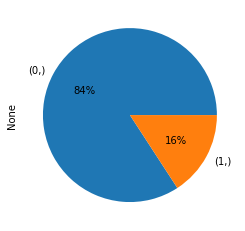

In [14]:
y_train.value_counts().plot(kind='pie', autopct='%1.0f%%');

## Procesar RCC

In [15]:
rcc_train = pd.read_csv(f'{path}/rcc_train.csv')
rcc_test = pd.read_csv(f'{path}/rcc_test.csv')

In [16]:
##### inputar datos faltantes en la base de rcc_test
rcc_test['cod_instit_financiera'].fillna(rcc_test['cod_instit_financiera'].value_counts().index[0], inplace=True)
rcc_test['PRODUCTO'].fillna(rcc_test['PRODUCTO'].value_counts().index[0], inplace=True)

In [17]:
dict_ = {'codmes': 'int32',
 'key_value': 'int32',
 'condicion': 'int32',
 'tipo_credito': 'int32',
 'cod_instit_financiera': 'int32',
 'PRODUCTO': 'int32',
 'RIESGO_DIRECTO': 'int32',
 'COD_CLASIFICACION_DEUDOR': 'int32'}
rcc_train = rcc_train.astype(dict_)
rcc_test = rcc_test.astype(dict_)

In [18]:
##### categorizar la variable condicion
bins = [-1, 0, 10, 20, 30, 60, 90, 180, 360, 720, float("inf")]
rcc_train["condicion"] = pd.cut(rcc_train.condicion, bins)
rcc_train["condicion"] = rcc_train["condicion"].cat.codes
rcc_test["condicion"] = pd.cut(rcc_test.condicion, bins)
rcc_test["condicion"] = rcc_test["condicion"].cat.codes

In [19]:
def get_filter_columns(df):
    keep_columns = set(keep_columns_final).intersection(set(df.columns))
    return df[keep_columns]

In [20]:
### definir las variables que seran agregadas
moda=lambda x: calculate_mode(x)
moda.__name__='mode'
agg_rcc = {'cod_instit_financiera':['nunique','min','max',moda],
           'PRODUCTO':['nunique','min','max',moda],
          }
def get_aggregate(df, desde,n):
    print(f'haciendo aggregate de cod_instit_financiera y Producto desde {desde}')
    df_result = df[df.codmes>=desde].groupby('key_value').agg(agg_rcc)
    df_result.columns = [feature+'_'+agg+f'_ult{n+1}mes' for feature, agg in df_result.columns]   
    df_result = get_filter_columns(df_result)
    gc.collect()  
    return df_result

In [21]:
def get_unstack(df, feature, desde, n, func):
    print(f'haciendo unstack de {feature} desde {desde} con la funcion de agregacion {func}')
    if func =='Sum':
        df_result = df[df.codmes>=desde].groupby(['key_value', feature]).saldo.sum().unstack(level = 1, fill_value=np.nan)
    if func == 'Unique':
        df_result = df[df.codmes>=desde].groupby(['key_value', feature]).saldo.size().unstack(level = 1, fill_value=np.nan)
    if func == 'Min':
        df_result = df[df.codmes>=desde].groupby(['key_value', feature]).saldo.min().unstack(level = 1, fill_value=np.nan)
    if func == 'Max':
        df_result = df[df.codmes>=desde].groupby(['key_value', feature]).saldo.max().unstack(level = 1, fill_value=np.nan)
    if func == 'Std':
        df_result = df[df.codmes>=desde].groupby(['key_value', feature]).saldo.std().unstack(level = 1, fill_value=np.nan)
    if func == 'Mean':
        df_result = df[df.codmes>=desde].groupby(['key_value', feature]).saldo.mean().unstack(level = 1, fill_value=np.nan)
    if func == 'Median':
        df_result = df[df.codmes>=desde].groupby(['key_value', feature]).saldo.median().unstack(level = 1, fill_value=np.nan)
    df_result.columns = [f'{df_result.columns.name}_{value}_saldo{func}_ult{n+1}meses' for value in df_result.columns]

    df_result = get_filter_columns(df_result)    
    gc.collect()      
    return df_result

In [22]:
rcc_train_list=[]
for n,desde in enumerate(sorted(set(rcc_train.codmes),reverse=True)):
    for feature in ['tipo_credito','RIESGO_DIRECTO','COD_CLASIFICACION_DEUDOR','condicion']:
        rcc_train_list.append(get_unstack(rcc_train, feature, desde, n, 'Sum'))
        rcc_train_list.append(get_unstack(rcc_train, feature, desde, n, 'Unique'))
        rcc_train_list.append(get_unstack(rcc_train, feature, desde, n, 'Min'))
        rcc_train_list.append(get_unstack(rcc_train, feature, desde, n, 'Max'))
        rcc_train_list.append(get_unstack(rcc_train, feature, desde, n, 'Std'))
        rcc_train_list.append(get_unstack(rcc_train, feature, desde, n, 'Mean'))
        rcc_train_list.append(get_unstack(rcc_train, feature, desde, n, 'Median'))
    rcc_train_list.append(get_aggregate(rcc_train, desde,n))

haciendo unstack de tipo_credito desde 201802 con la funcion de agregacion Sum
haciendo unstack de tipo_credito desde 201802 con la funcion de agregacion Unique
haciendo unstack de tipo_credito desde 201802 con la funcion de agregacion Min
haciendo unstack de tipo_credito desde 201802 con la funcion de agregacion Max
haciendo unstack de tipo_credito desde 201802 con la funcion de agregacion Std
haciendo unstack de tipo_credito desde 201802 con la funcion de agregacion Mean
haciendo unstack de tipo_credito desde 201802 con la funcion de agregacion Median
haciendo unstack de RIESGO_DIRECTO desde 201802 con la funcion de agregacion Sum
haciendo unstack de RIESGO_DIRECTO desde 201802 con la funcion de agregacion Unique
haciendo unstack de RIESGO_DIRECTO desde 201802 con la funcion de agregacion Min
haciendo unstack de RIESGO_DIRECTO desde 201802 con la funcion de agregacion Max
haciendo unstack de RIESGO_DIRECTO desde 201802 con la funcion de agregacion Std
haciendo unstack de RIESGO_DIREC

In [23]:
rcc_train = pd.concat(rcc_train_list, axis=1)
del rcc_train_list

In [24]:
rcc_test_list=[]
for n,desde in enumerate(sorted(set(rcc_test.codmes),reverse=True)):
    for feature in ['tipo_credito','RIESGO_DIRECTO','COD_CLASIFICACION_DEUDOR','condicion']:
        rcc_test_list.append(get_unstack(rcc_test, feature, desde, n, 'Sum'))
        rcc_test_list.append(get_unstack(rcc_test, feature, desde, n, 'Unique'))
        rcc_test_list.append(get_unstack(rcc_test, feature, desde, n, 'Min'))
        rcc_test_list.append(get_unstack(rcc_test, feature, desde, n, 'Max'))
        rcc_test_list.append(get_unstack(rcc_test, feature, desde, n, 'Std'))
        rcc_test_list.append(get_unstack(rcc_test, feature, desde, n, 'Mean'))
        rcc_test_list.append(get_unstack(rcc_test, feature, desde, n, 'Median'))
    rcc_test_list.append(get_aggregate(rcc_test, desde,n))

haciendo unstack de tipo_credito desde 201902 con la funcion de agregacion Sum
haciendo unstack de tipo_credito desde 201902 con la funcion de agregacion Unique
haciendo unstack de tipo_credito desde 201902 con la funcion de agregacion Min
haciendo unstack de tipo_credito desde 201902 con la funcion de agregacion Max
haciendo unstack de tipo_credito desde 201902 con la funcion de agregacion Std
haciendo unstack de tipo_credito desde 201902 con la funcion de agregacion Mean
haciendo unstack de tipo_credito desde 201902 con la funcion de agregacion Median
haciendo unstack de RIESGO_DIRECTO desde 201902 con la funcion de agregacion Sum
haciendo unstack de RIESGO_DIRECTO desde 201902 con la funcion de agregacion Unique
haciendo unstack de RIESGO_DIRECTO desde 201902 con la funcion de agregacion Min
haciendo unstack de RIESGO_DIRECTO desde 201902 con la funcion de agregacion Max
haciendo unstack de RIESGO_DIRECTO desde 201902 con la funcion de agregacion Std
haciendo unstack de RIESGO_DIREC

In [25]:
rcc_test = pd.concat(rcc_test_list, axis=1)
del rcc_test_list

In [26]:
### unir RCC en la base final
train = rcc_train
test = rcc_test
del rcc_train, rcc_test

## Procesar SE

In [27]:
se_train = pd.read_csv(f'{path}/se_train.csv', index_col = 'key_value')
se_test = pd.read_csv(f'{path}/se_test.csv', index_col = 'key_value')

In [28]:
dict_ = {'sexo':'int32',
         'est_cvl':'int32',
         'sit_lab':'int32',
         'cod_ocu':'int32',
         'ctd_hijos':'int32',
         'flg_sin_email':'int32',
         'ctd_veh':'int32',
         'lgr_vot':'int32',
         'prv':'int32',
         'dto':'int32',
         'rgn':'int32',
         'tip_lvledu':'int32'}
se_train = se_train.astype(dict_)
se_test = se_test.astype(dict_)

In [29]:
def get_one_hot(df, feature):
    one_hot = pd.get_dummies(df[feature])
    one_hot.columns = [feature+'_'+str(i) for i in one_hot.columns]
    return one_hot
one_hot_sexo_train = get_one_hot(se_train, 'sexo')
one_hot_sexo_test = get_one_hot(se_test, 'sexo')
one_hot_est_cvl_train = get_one_hot(se_train, 'est_cvl')
one_hot_est_cvl_test = get_one_hot(se_test, 'est_cvl')
one_hot_rgn_train = get_one_hot(se_train, 'rgn')
one_hot_rgn_test = get_one_hot(se_test, 'rgn')

In [30]:
train = train.join(one_hot_sexo_train).join(one_hot_est_cvl_train).join(one_hot_rgn_train).join(se_train[['edad','ctd_veh']])
test = test.join(one_hot_sexo_test).join(one_hot_est_cvl_test).join(one_hot_rgn_test).join(se_test[['edad','ctd_veh']])
del se_train, se_test

## Procesar SUNAT

In [31]:
sunat_train = pd.read_csv(f'{path}/sunat_train.csv')
sunat_test = pd.read_csv(f'{path}/sunat_test.csv')

In [32]:
### eliminar registros duplicados
sunat_train.drop_duplicates(inplace=True)
sunat_test.drop_duplicates(inplace=True)
sunat_train.shape, sunat_test.shape

((292479, 18), (318821, 18))

In [33]:
dict_ = {'tipcontribuyente': 'int32',
         'tippersona': 'int32',
         'ciiu': 'int32',
         'ubigeo': 'int32',
         'condiciondomicilio': 'int32',
         'estadocontribuyente': 'int32',
         'codvia': 'int32',
         'codzona': 'int32',
         'contabilidad': 'int32',
         'facturacion': 'int32',
         'domiciliado': 'int32',
         'comercioexterior': 'int32',
         'cargorele': 'int32',
         'codentidadtributo': 'int32',
         'estadotributo': 'int32'}
sunat_train = sunat_train.astype(dict_)
sunat_test = sunat_test.astype(dict_)

In [34]:
sunat_train['diff_fech'] = sunat_train['fecbaja'] - sunat_train['fecalta']
sunat_test['diff_fech'] = sunat_test['fecbaja'] - sunat_test['fecalta']

In [35]:
moda=lambda x: calculate_mode(x)
moda.__name__='mode'
agg_sunat = {
            'tipcontribuyente':['nunique',moda],
            'tippersona':['nunique',moda],
            'ciiu':['nunique', moda],
            'ubigeo':['nunique',moda],
           'condiciondomicilio':['nunique',moda],  ####
#            'estadocontribuyente':['nunique',moda],
           'codvia':['nunique',moda],
           'codzona':['nunique',moda],
           'contabilidad':['nunique',moda],
           'facturacion':['nunique',moda],
           'domiciliado':['nunique',moda],
           'comercioexterior':['nunique',moda],
           'cargorele':['nunique',moda],
           'codentidadtributo':['nunique',moda], ####
           'estadotributo':['nunique',moda], ####
           'fecalta':['mean','max', 'nunique','min','std'],
           'fecbaja':['mean','max', 'nunique','min'], 
           'diff_fech':['mean','max', 'nunique','min'], 
            }
sunat_train_agg = sunat_train.groupby('key_value').agg(agg_sunat)
sunat_train_agg.columns = [i+'_'+j for i,j in sunat_train_agg.columns]
sunat_test_agg = sunat_test.groupby('key_value').agg(agg_sunat)
sunat_test_agg.columns = [i+'_'+j for i,j in sunat_test_agg.columns]
# del sunat_train, sunat_test

In [36]:
crosstab_estadocontribuyente_train = get_crosstab(sunat_train, 'key_value', 'estadocontribuyente')
crosstab_estadocontribuyente_test = get_crosstab(sunat_test, 'key_value', 'estadocontribuyente')

In [37]:
gc.collect()

20

In [38]:
train, test = optimize_dtypes(train, test)

In [39]:
train = train.join(crosstab_estadocontribuyente_train).join(sunat_train_agg)
test = test.join(crosstab_estadocontribuyente_test).join(sunat_test_agg)
train, test = get_keep_columns(train, test)
del sunat_train_agg, sunat_test_agg, sunat_train, sunat_test

(358487, 847) (396666, 846)
(358487, 846) (396666, 846)


In [40]:
train, test = optimize_dtypes(train, test)

In [41]:
train = get_filter_columns(train)
test = get_filter_columns(test)
train.shape, test.shape

((358487, 810), (396666, 810))

## Aggregate Unstack de cod_instit_financiera and PRODUCTO del ultimo primer, segundo, tercero y doceavo mes

In [42]:
aux_meses =  [(0, 201802, 201902), (1, 201801, 201901), (2, 201712, 201812), (11, 201703, 201803)]
list_rcc_train = []
list_rcc_test = []
for n,desde_train, desde_test in aux_meses:
    rcc_train, rcc_test = get_rcc()

    rcc_train_list = get_rcc_list(rcc_train,desde_train, n)
    rcc_test_list = get_rcc_list(rcc_test,desde_test, n)

    rcc_train = pd.concat(rcc_train_list, axis=1)
    rcc_test = pd.concat(rcc_test_list, axis=1)
    del rcc_train_list, rcc_test_list
    
    
    rcc_train, rcc_test = optimize_dtypes(rcc_train, rcc_test)
    
    rcc_train = get_filter_columns(rcc_train)
    rcc_test = get_filter_columns(rcc_test)
    
    print(rcc_train.shape, rcc_test.shape)
    
    list_rcc_train.append(rcc_train)
    list_rcc_test.append(rcc_test)
    
    gc.collect()
    
    del rcc_train, rcc_test

haciendo unstack de cod_instit_financiera desde 201802 con la funcion de agregacion Sum
haciendo unstack de cod_instit_financiera desde 201802 con la funcion de agregacion Unique
haciendo unstack de cod_instit_financiera desde 201802 con la funcion de agregacion Min
haciendo unstack de cod_instit_financiera desde 201802 con la funcion de agregacion Max
haciendo unstack de cod_instit_financiera desde 201802 con la funcion de agregacion Std
haciendo unstack de cod_instit_financiera desde 201802 con la funcion de agregacion Mean
haciendo unstack de cod_instit_financiera desde 201802 con la funcion de agregacion Median
haciendo unstack de PRODUCTO desde 201802 con la funcion de agregacion Sum
haciendo unstack de PRODUCTO desde 201802 con la funcion de agregacion Unique
haciendo unstack de PRODUCTO desde 201802 con la funcion de agregacion Min
haciendo unstack de PRODUCTO desde 201802 con la funcion de agregacion Max
haciendo unstack de PRODUCTO desde 201802 con la funcion de agregacion Std

In [43]:
rcc_train = pd.concat(list_rcc_train, axis=1)
rcc_test = pd.concat(list_rcc_test, axis=1)
del list_rcc_train, list_rcc_test
rcc_train.shape, rcc_test.shape

((358487, 818), (396666, 818))

In [44]:
train = train.join(rcc_train)
train = train[keep_columns_final]
test = test.join(rcc_test)
test = test[keep_columns_final]
del rcc_train, rcc_test 
train.shape, test.shape

((358487, 1628), (396666, 1628))

In [45]:
gc.collect()

20

In [46]:
train.to_pickle('../data/train_1628features.pkl')
test.to_pickle('../data/test_1628features.pkl')